# Definitions and imports

In [6]:
import torch

torch.cuda.set_device(0)
device = torch.device("cuda:0")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import math
sys.path.append("../../packages/")

from utilities import *
from made import *
from global_steps import *

In [2]:
def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

import numpy as np
from scipy.special import comb
from scipy.optimize import fsolve

# Function to compute p(k)
def p_k_single(k, i, m_hat):
    coeff = comb(i - 1, k)  # Binomial coefficient
    term1 = ((1 + m_hat) / 2) ** k
    term2 = ((1 - m_hat) / 2) ** (i - 1 - k)
    return coeff * term1 * term2

def p_k(i, mhat):
    pk = np.zeros(i)
    for k in range(0, i):
        pk[k] = p_k_single(k, i, mhat)
    return pk

# Self-consistent equation for \hat{m}
def self_consistent_eq(m_hat, beta):
    return m_hat - np.tanh(beta * m_hat)

# Solve for \hat{m}
def solve_m_hat(beta):
    m_hat_initial = 0.5  # Initial guess for \hat{m}
    m_hat_solution = fsolve(self_consistent_eq, m_hat_initial, args=(beta,))
    return m_hat_solution[0]

def solve_Ji(beta, i, m_hat, start_J):
    """Solve for the single Ji (does not depend on the others)"""
    pk = p_k(i, m_hat)
    m_hat_squared = m_hat ** 2

    def J_i_eq(J_i):
        sum = 0
        for k in range(0, i):
            factor = (2 * k - i + 1) / (i - 1)
            sum += pk[k] * factor * np.tanh((2*k-i+1)*J_i)
        return m_hat_squared - sum
    J_i = fsolve(J_i_eq, start_J)[0] 
    return J_i

def solve_allJ(beta, N, m_hat):
    """Solve for all the Ji values"""
    all_J = np.zeros(N-1)
    start_J = 0
    for i in range(2, N+1):
        all_J[i-2] = solve_Ji(beta, i, m_hat, start_J)
        start_J = all_J[i-2]

    return np.array(all_J)


# Main function
def solver(beta, N):
    # Step 1: Solve for \hat{m}
    m_hat_solution = solve_m_hat(beta)

    # Step 2: Solve for J_i values using the solved \hat{m}
    J_i_solutions = solve_allJ(beta, N, m_hat_solution)

    return m_hat_solution, J_i_solutions


In [3]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ExponentialLR

#set device to "cuda" if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

def enforce_same_coupling_per_row(module):
    if hasattr(module, 'weight'):
        with torch.no_grad():
            w = module.weight.data
            # Loop over rows and enforce that each row's lower-triangular (allowed) weights are identical.
            for i in range(w.size(0)):
                if i > 0:  # Skip row 0 if there are no lower entries
                    # Compute average of the allowed weights (only consider entries that are not masked out)
                    row_avg = w[i, :i].mean()
                    w[i, :i] = row_avg  # Set all allowed weights to this average
            module.weight.data = w

# Train the model
def train_made_shared_row(dataset, input_size, epochs=50, batch_size=256, learning_rate=1e-3):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss(reduction="sum")

    for epoch in tqdm(range(epochs)):
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
            model.apply(enforce_same_coupling_per_row)

    return model

In [ ]:
def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

In [5]:
def montecarlo_CW(N, beta, pop_size, num_sweeps):
    # Population of spins, randomly initialized to -1 or 1
    pop = 2.*torch.randint(0, 2, (pop_size, N), device="cuda") - 1.

    
    # Loop to update the population using the Monte Carlo method
    for i in range(0, num_sweeps):  # Maximum number of iterations
        for n in range(N):
            # Perform a Monte Carlo update for the entire population
            pop = monte_carlo_update_CW(pop, N, beta)
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return pop

# Comparison with the MADE

In [114]:
N = 20
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model_exact = setup_model(W, N = N)
data_B1 = generate_config_fast(model_exact, N, 100000, None)
data_B1_2 = generate_config_fast(model_exact, N, 100000, None)

In [115]:
pop_size = 5000000
num_sweeps = 30
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)
#test = montecarlo_CW(N, beta, pop_size, num_sweeps)

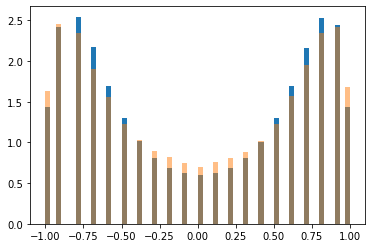

In [ ]:
res_B1 = plt.hist(pop.mean(1).cpu().numpy(), bins=60, density=True)
plt.hist(data_B1.mean(1).cpu().numpy(), bins=res_B1[1], alpha = 0.5, density=True, label=r"$\beta = 1$")


plt.show()

In [ ]:
mymade = train_made(pop[:100000], N)

 28%|██▊       | 14/50 [00:12<00:32,  1.10it/s]


KeyboardInterrupt: 

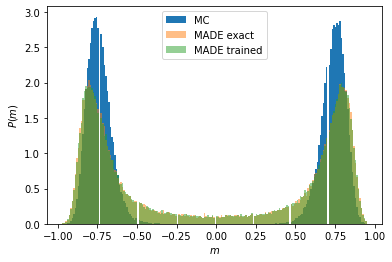

In [ ]:
x1 = generate_config_fast(mymade, N, 100000, None)

res_B1 = plt.hist(pop[-100000:].mean(1).cpu().numpy(), bins=200, density=True, label = "MC")
plt.hist(data_B1.mean(1).cpu().numpy(), bins=res_B1[1], alpha = 0.5, density=True, label  = "MADE exact")
plt.hist(x1.mean(1).cpu().numpy(), bins=res_B1[1], alpha = 0.5, density=True, label = "MADE trained")
#plt.hist(data_factor.cpu().numpy(), bins=res_B1[1], alpha = 0.5, density=True, label=r"$\beta = 1$")

plt.legend()
plt.xlabel(f"$m$")
plt.ylabel(f"$P(m)$")


plt.show()

# Test sulla convergenza

## Definitions

In [53]:
def get_error(model, optimal):
    diffs = (-model_exact.layer.weight + model.layer.weight).sum(1)
    diffs[1:]/= torch.arange(1, len(diffs), device = "cuda")
    return diffs

def train_made_save_distances(dataset, input_size, optimal, start = "optimal", pert_type = "uniform_small", epochs=1, optimizer = "SGD", batch_size=256, patience = 10, learning_rate = 0.001, scheduler_time = 10):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    # Set model.layer.weights to optimal, then add a small Gaussian perturbation
    with torch.no_grad():
        if start == "optimal":
            model.layer.weight = nn.Parameter(optimal.clone())
        elif start == "random":
            pass # layers are already initialized randomly 
        elif start == "zero":
            model.layer.weight = nn.Parameter(torch.zeros_like(model.layer.weight))
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'optimal' and 'random'")
        if pert_type == "uniform_small":
            perturbation = 0.01
        elif pert_type == "uniform_large":
            perturbation = 0.3
        elif pert_type == "none":
            perturbation = 0
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'uniform_small', 'uniform_large' and 'none'")
        model.layer.weight += perturbation
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    distances = []

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not supported. Supported optimizers are 'SGD' and 'Adam'")
    criterion = nn.BCELoss(reduction="mean")
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    for epoch in tqdm(range(epochs)):
        tot_loss = 0
        count = 0
        distance = get_error(model, optimal)
        distances.append(distance)
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)
            tot_loss += loss
            count += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
    
    distance = get_error(model, optimal)
    distances.append(distance)
    return model, distances

def train_different_epochs(dataset, input_size, optimal, epochs_save, start = "optimal", pert_type = "uniform_small", epochs=1, optimizer = "SGD", batch_size=256, patience = 10, learning_rate = 0.001, scheduler_time = 10):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    # Set model.layer.weights to optimal, then add a small Gaussian perturbation
    with torch.no_grad():
        if start == "optimal":
            model.layer.weight = nn.Parameter(optimal.clone())
        elif start == "random":
            pass # layers are already initialized randomly 
        elif start == "zero":
            model.layer.weight = nn.Parameter(torch.zeros_like(model.layer.weight))
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'optimal' and 'random'")
        if pert_type == "uniform_small":
            perturbation = 0.01
        elif pert_type == "uniform_large":
            perturbation = 0.3
        elif pert_type == "none":
            perturbation = 0
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'uniform_small', 'uniform_large' and 'none'")
        model.layer.weight += perturbation
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    weights = []

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not supported. Supported optimizers are 'SGD' and 'Adam'")
    criterion = nn.BCELoss(reduction="mean")
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    for epoch in tqdm(range(epochs)):
        tot_loss = 0
        count = 0
        if epoch in epochs_save:
            with torch.no_grad():
                res = model.layer.weight.sum(1)
                res[1:]/= torch.arange(1, len(res), device = "cuda")
                weights.append(res.cpu().numpy())
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)
            tot_loss += loss
            count += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
    
    return model, weights

In [9]:
def gradients_computer(dataset, input_size, optimal, epsilon=0.1, num_points=20):

    # Assume that the device (cpu or cuda) is already defined globally
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Clone dataset and move to device when needed.
    data = torch.clone(dataset)

    model = made(input_size)  # assume your MADE model definition is available
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr = 0)
    criterion = nn.BCELoss(reduction="sum")


    num_rows, num_cols = N, N
    
    # This dictionary will store, for each row i, a list of tuples (candidate J, gradient)
    gradients = {}
    
    # For each row, extract the optimal value (we use the first allowed index, j=0 for lower triangular)
    for i in range(0, num_rows):
        gradients[i] = []
        # Determine the allowed (nonzero) positions for row i.
        # For a lower triangular matrix, allowed columns are those with index <= i.
        allowed_mask = torch.arange(num_cols, device=device) < i  # boolean mask for row i
        
        # Candidate offsets around the optimal value for row i.
        # Here, we take the optimal value from the first allowed element.
        optimal_J_i = optimal[i]
        candidate_offsets = torch.linspace(-epsilon*optimal_J_i, epsilon*optimal_J_i, steps=num_points, device=device)
        
        for offset in candidate_offsets:
            candidate_value = optimal_J_i + offset
            # Create a new weight matrix by copying the best weight
            new_weight = torch.zeros_like(model.layer.weight)
            # Set row i's allowed positions to candidate_value (forcing the tied structure)
            new_weight[i, allowed_mask] = candidate_value
            # Make this tensor require gradients.
            new_weight = new_weight.clone().detach().requires_grad_(True)
            # Temporarily override the model's weight parameter.
            model.layer.weight = nn.Parameter(new_weight)
            
            # Zero any existing gradients
            optimizer.zero_grad()
            
            # Forward pass on the evaluation batch
            output = model(data)
            loss = criterion(output, (data + 1) / 2) / len(data)
            loss.backward()
            
            # Since all allowed entries in row i are tied, we take the mean of their gradients.
            if i != 0:
                grad_i = model.layer.weight.grad[i, allowed_mask].sum().item()
            else:
                grad_i = 0
            gradients[i].append((candidate_value.item()-optimal_J_i, grad_i))
    
    return gradients


## Tests

### Behaviour of the Gradient around the optimal point

First, we compare the numerically-evaluated gradient with the one obtained from the Hessian

In [118]:
gradients = gradients_computer(pop, N, W)

Angular coefficient for key 1: 0.955767053332159
Angular coefficient for key 7: 11.713491469830906
Angular coefficient for key 14: 36.175063247187715
Angular coefficient for key 19: 61.680950600291595


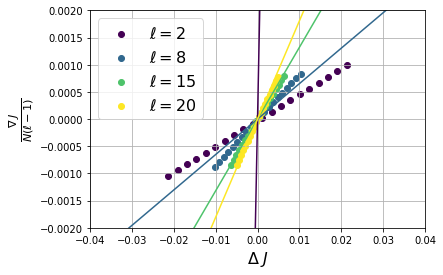

In [ ]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=19)
hessian = np.loadtxt("hessian_N20_beta1.3.txt")

# Repeat the plot for some values of the keys (1, 6, 10)
for key in [1, 7,14,19]:
    # Perform a linear fit
    gradient_values = gradients[key]
    candidate_values = [item[0] for item in gradient_values]
    gradient_magnitudes = np.array([item[1] for item in gradient_values])
    coeffs = np.polyfit(candidate_values, gradient_magnitudes, 1)
    angular_coefficient = coeffs[0]
    print(f'Angular coefficient for key {key}: {angular_coefficient}')
    #print(f'Manual AC {key}: {(gradient_magnitudes[0]-gradient_magnitudes[-1])/(candidate_values[0]-candidate_values[-1])}')
    plt.plot(np.linspace(-0.04,0.04,10), np.linspace(-0.04,0.04,10)*hessian[key-1,1]/key/N, color = cmap(norm(key)))
    plt.scatter(candidate_values, gradient_magnitudes/key/N, color=cmap(norm(key)), label = rf"$\ell = {key+1}$")
plt.xlabel(f'$\Delta \; J$', fontsize = 16)
plt.ylabel(r'$\frac{\nabla \; J}{N(\ell-1)}$', fontsize = 16)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.002, 0.002)
plt.legend(fontsize = 16)

#plt.title(f'Scatter Plot of Gradients for Index {key}')
plt.grid(True)
plt.show()

We then compare the analytics with the evolution in time of the norm of the perturbations

In [ ]:
num_epochs = 20
lr = 0.1
model, distances  = train_made_save_distances(pop[:500000], N, model_exact.layer.weight, epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=500000)

100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

20


1 0.04840321011013454
2 0.044275654686821826
3 0.05629407034979926
4 0.057588683234320745
5 0.06721258163452148
6 0.08087343639797635
7 0.09513298670450845
8 0.09650972154405381
9 0.10531372494167753
10 0.11371639039781357
11 0.11807786093817817
12 0.13584825727674696
13 0.14801608191596136
14 0.15013800726996526
15 0.15129963556925455
16 0.1636997858683268
17 0.1805061764187283
18 0.19004053539699978
19 0.20408074061075845


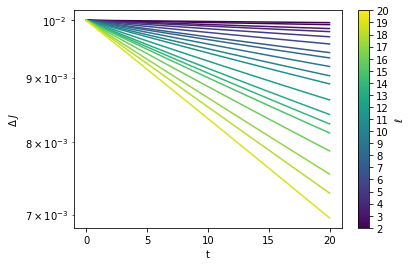

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert distances to numpy array
distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])

numerics = []

# Plot the distances for all keys from 1 to 19
plt.figure()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)
for key in range(1, 20):
    plt.plot(distances_np[:, key] - distances_np[0, key] + 0.01, label=f'$\ell =  {key+1}$', color=cmap(norm(key)))
    print(key, (np.log(distances_np[1, key])-np.log(distances_np[-1, key]))/(num_epochs-2)/lr )
    numerics.append([key, (np.log(distances_np[1, key])-np.log(distances_np[-1, key]))/(num_epochs-2)/lr])
plt.xlabel('t')
plt.ylabel(rf'$\Delta \; J$')
plt.yscale("log")
#plt.xlim(0, 5)
#plt.legend()

# Add color column to the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 21), label='$\ell$')

plt.show()

numerics = np.array(numerics)

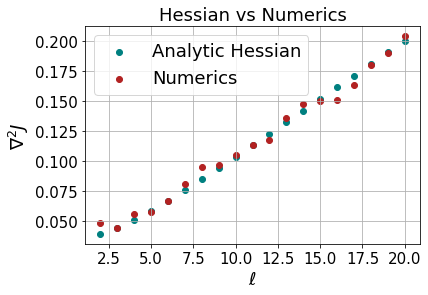

In [ ]:
plt.scatter(hessian[:,0], hessian[:,1], color='teal', label='Analytic Hessian')
plt.scatter(numerics[:,0]+1, numerics[:,1], color='firebrick', label='Numerics')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\nabla^2 J$')
plt.title('Hessian vs Numerics', fontsize=18)
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'$\nabla^2 J$', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

### Behaviour at the start of the dynamics

In [ ]:
num_epochs = 200
lr = 1
model, distances  = train_made_save_distances(pop[:500000], N, model_exact.layer.weight, start = "optimal", pert_type="uniform_large", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=500000)

100%|██████████| 200/200 [01:29<00:00,  2.22it/s]


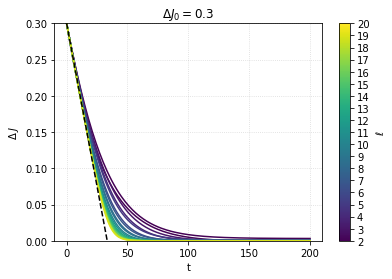

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert distances to numpy array
distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])

numerics = []

# Plot the distances for all keys from 1 to 19
plt.figure()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)
for key in range(1, 20):
    plt.plot(distances_np[:, key], label=f'$\ell =  {key+1}$', color=cmap(norm(key)))
plt.xlabel('t')
plt.ylabel(rf'$\Delta \; J$')
#plt.legend()
plt.ylim(0,0.3)

A = 0.3
B = -0.009
x_vals = np.arange(len(distances_np))
plt.plot(x_vals, A + B * x_vals, label=f'Linear fit: {A} + {B}*x', color='k', linestyle='--')

# Add color column to the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 21), label='$\ell$')
plt.grid(True, alpha = 0.5, ls =":")

plt.title(r"$\Delta J_0 = 0.3$")
plt.show()

numerics = np.array(numerics)

In [ ]:
num_epochs = 200
lr = 1
model, distances  = train_made_save_distances(pop[:500000], N, model_exact.layer.weight, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=500000)

100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


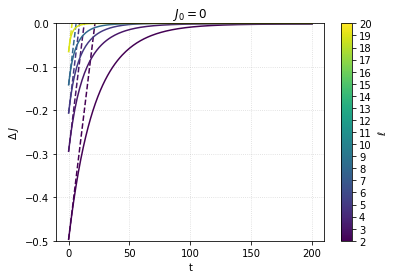

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert distances to numpy array
distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])

numerics = []

keys = [1,3, 5, 8, 19]
Alist = -W[keys]
Blist = [0.0229704,0.0229704,0.0229704,0.0229704,0.0229704]

# Plot the distances for all keys from 1 to 19
plt.figure()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)
for n, key in enumerate(keys):
    plt.plot(distances_np[:, key], label=f'$\ell =  {key+1}$', color=cmap(norm(key)))
    A = Alist[n]
    B = Blist[n]
    x_vals = np.arange(len(distances_np))
    plt.plot(x_vals, A + B * x_vals, label=f'Linear fit: {A} + {B}*x',  color=cmap(norm(key)), linestyle='--')
plt.xlabel('t')
plt.ylabel(rf'$\Delta \; J$')
#plt.legend()
plt.ylim(-0.5,0)

# Add color column to the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 21), label='$\ell$')
plt.grid(True, alpha = 0.5, ls =":")
plt.title(r"$J_0 = 0$")
plt.show()

numerics = np.array(numerics)

In [ ]:
num_epochs = -1
lr = 1
pop_size = 50000
model, distances  = train_made_save_distances(pop[:pop_size], N, model_exact.layer.weight, start = "random", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=pop_size)

0it [00:00, ?it/s]


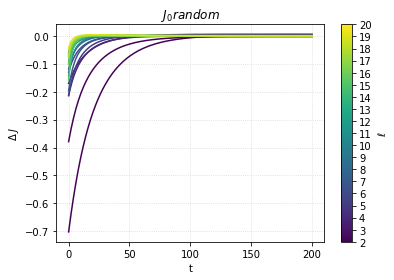

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert distances to numpy array
distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])

numerics = []

# Plot the distances for all keys from 1 to 19
plt.figure()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)
for key in range(1, 20):
    plt.plot(distances_np[:, key], label=f'$\ell =  {key+1}$', color=cmap(norm(key)))
plt.xlabel('t')
plt.ylabel(rf'$\Delta \; J$')
#plt.legend()

A = 0.3
B = -0.009
x_vals = np.arange(len(distances_np))
#plt.plot(x_vals, A + B * x_vals, label=f'Linear fit: {A} + {B}*x', color='k', linestyle='--')

# Add color column to the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 21), label='$\ell$')
plt.grid(True, alpha = 0.5, ls =":")

plt.title(r"$J_0 random$")
plt.show()

numerics = np.array(numerics)

The Adam case

In [ ]:
num_epochs = 200
tot_distances = []
learning_rates = [0.1, 0.01, 0.005]
for lr in learning_rates:
    model, distances  = train_made_save_distances(pop[:50000], N, model_exact.layer.weight, start = "optimal", pert_type="uniform_large", epochs = num_epochs, learning_rate=lr, optimizer = "Adam", patience=10000, scheduler_time = 1000, batch_size=50000)
    tot_distances.append(distances)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:07<00:00, 26.23it/s]


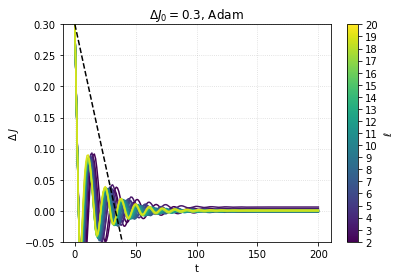

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

distances = tot_distances[0]

# Convert distances to numpy array
distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])

numerics = []

# Plot the distances for all keys from 1 to 19
plt.figure()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)
for key in range(1, 20):
    plt.plot(distances_np[:, key], label=f'$\ell =  {key+1}$', color=cmap(norm(key)))
plt.xlabel('t')
plt.ylabel(rf'$\Delta \; J$')
#plt.legend()
plt.ylim(-0.05,0.3)

A = 0.3
B = -0.009
x_vals = np.arange(len(distances_np))
plt.plot(x_vals, A + B * x_vals, label=f'Linear fit: {A} + {B}*x', color='k', linestyle='--')

# Add color column to the right
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 21), label='$\ell$')
plt.grid(True, alpha = 0.5, ls =":")

plt.title(r"$\Delta J_0 = 0.3$, Adam")
plt.show()

numerics = np.array(numerics)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


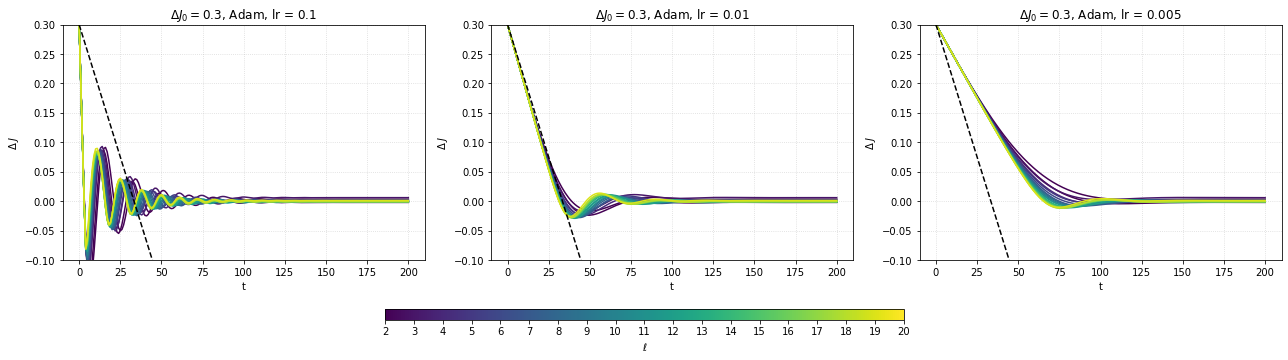

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=2, vmax=20)

# Constants for the linear fit
A = 0.3
B = -0.009

# Loop over the tot_distances list and create a plot for each element
for i, distances in enumerate(tot_distances):
    # Convert each distances list to a NumPy array
    distances_np = np.array([dist.cpu().detach().numpy() for dist in distances])
    ax = axes[i]
    
    # Plot curves for keys 1 to 19
    for key in range(1, 20):
        ax.plot(distances_np[:, key], label=f'$\ell = {key+1}$', color=cmap(norm(key)))
    
    # Set axis labels and limits
    ax.set_xlabel('t')
    ax.set_ylabel(r'$\Delta \; J$')
    ax.set_ylim(-0.1, 0.3)
    
    # Plot the linear fit
    x_vals = np.arange(len(distances_np))
    ax.plot(x_vals, A + B * x_vals, label=f'Linear fit: {A} + {B}*x', color='k', linestyle='--')
    
    # Add grid and title
    ax.grid(True, alpha=0.5, ls=":")
    ax.set_title(rf"$\Delta J_0 = 0.3$, Adam, lr = {learning_rates[i]}")

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Adjust the figure to create space at the bottom for the colorbar
fig.subplots_adjust(bottom=0.25)

# Add a horizontal colorbar centered below the subplots
# [left, bottom, width, height] defines the colorbar position relative to the figure
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=range(1, 21))
cbar.set_label('$\ell$')

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()


# Test sulla convergenza del campione utilizzando $\chi^2$-divergence

## Definitions

In [7]:
def compute_chi2_divergence(P, Q, eps=1e-10):
    """
    Computes the Pearson Chi² divergence between two empirical distributions.

    Args:
        P (torch.Tensor): Tensor of probabilities for distribution P.
        Q (torch.Tensor): Tensor of probabilities for distribution Q.
        eps (float): A small constant to avoid division by zero.

    Returns:
        torch.Tensor: The computed Chi² divergence.
    """
    # Ensure Q has no zeros by replacing values below eps
    Q_safe = torch.where(Q < eps, torch.full_like(Q, eps), Q)
    
    # Compute the ratio P / Q_safe
    ratio = P / Q_safe
    
    # Compute Chi² divergence: sum_x Q(x) * ((P(x) / Q(x)) - 1)^2
    divergence = torch.sum(Q_safe * (ratio - 1) ** 2)
    
    return divergence

def compute_magnetization_histogram(population, num_bins=None):
    """
    Computes the normalized histogram of magnetizations for a population of spin configurations.

    Args:
        population (torch.Tensor): A tensor of shape (N_elements, N_spins) representing the spin configurations.
                                   Each row is one configuration.
        num_bins (int, optional): Number of bins for the histogram. If None, it will use the range of magnetization values.
        
    Returns:
        torch.Tensor: A tensor representing the normalized histogram (i.e., probability distribution) of magnetizations.
    """
    # Compute the magnetization of each element by summing over spins.
    # Adjust the reduction (e.g., mean vs. sum) if needed.
    magnetizations = population.sum(dim=1).float()
    
    # Determine the range for the histogram from the computed magnetizations.
    m_min, m_max = magnetizations.min().item(), magnetizations.max().item()
    
    # If num_bins is not provided, use one bin for each distinct integer value in the range.
    # This assumes that the magnetization values are integer-valued.
    if num_bins is None:
        num_bins = int(m_max - m_min + 1)
    
    # Compute the histogram using torch.histc.
    # Note: torch.histc requires the min and max values.
    hist = torch.histc(magnetizations, bins=num_bins, min=m_min, max=m_max)
    
    # Normalize the histogram so that it sums to 1 (i.e., it's a probability distribution).
    hist_normalized = hist / hist.sum()
    
    return hist_normalized

def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population


## Results

In [8]:
def montecarlo_globalstep(N, beta, model, pop_start, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop =  torch.clone(pop_start)
    pop_size = pop.shape[0]
    
    pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
    for i in range(N*k):
        pop = monte_carlo_update_CW(pop, N, beta)  
    return pop

In [9]:
pop_size = 500000
num_sweeps = 30
beta_start = 1
beta_target = 1.2
N = 20

pop1 = montecarlo_CW(N, 1, pop_size, num_sweeps)
pop2 = montecarlo_CW(N, beta_target, pop_size, num_sweeps)
lr = 1

KeyboardInterrupt: 

In [ ]:
complete_divergences = []
epochs_list = [1,5,10,20,50]
for num_epochs in epochs_list:
    model, distances  = train_made_save_distances(pop1, N, model_exact.layer.weight, start = "optimal", pert_type="uniform_large", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=pop_size)
    all_divergences = []
    for k in [0,1]:
        divs = []
        pop1 = montecarlo_CW(N, 1, pop_size, num_sweeps)
        pop2 = montecarlo_CW(N, beta_target, pop_size, num_sweeps)
        for i in range(100):
            div = compute_chi2_divergence(compute_magnetization_histogram(pop1, num_bins = 2*N+1),compute_magnetization_histogram(pop2, num_bins = 2*N+1))    
            pop1 = montecarlo_globalstep(N, beta_target, model, pop1, k = k)
            divs.append(div)
        all_divergences.append(divs)
    complete_divergences.append(all_divergences)

100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


In [ ]:
style = ["-", "--"]
for i, all_divergences in enumerate(complete_divergences):
    for n,d in enumerate(all_divergences):
        plt.plot((N*(n*0+1))*np.arange(len(d)), d, color=plt.cm.viridis(i / len(complete_divergences)), label=f'k={n}', ls = style[n])
plt.xlabel('Steps')
plt.ylabel('Divergence')
plt.legend()
plt.grid(True)
plt.xlim(0,200)

NameError: name 'complete_divergences' is not defined

# Analytical test

In [58]:
from scipy.special import expit

def compute_Pm(J):
    N = len(J)
    # Initialize the probability distribution: only m = 0 has probability 1
    prob = {0: 1.0}
    for l in range(N):
        new_prob = {}
        for m, p in prob.items():
            x = 2 * J[l] * m  # Note: x = 2*J_l*m
            p_up = expit(x)   # Numerically stable logistic function
            p_down = 1.0 - p_up
            new_prob[m + 1] = new_prob.get(m + 1, 0.0) + p * p_up
            new_prob[m - 1] = new_prob.get(m - 1, 0.0) + p * p_down
        prob = new_prob
    return prob


In [ ]:
def compute_Pm(J):
    N = J.shape[0]
    dp = torch.zeros(2 * N + 1, dtype=J.dtype, device=J.device)
    dp[N] = 1.0
    m_vector = torch.arange(-N, N + 1, dtype=J.dtype, device=J.device)
    for l in range(N):
        new_dp = torch.zeros_like(dp)
        up = torch.sigmoid(2 * J[l] * m_vector[:-1])
        new_dp[1:] += dp[:-1] * up
        down = 1 - torch.sigmoid(2 * J[l] * m_vector[1:])
        new_dp[:-1] += dp[1:] * down
        dp = new_dp
    return dp

In [60]:
def transition_matrix_global(probMADE, beta, N):
    M = len(probMADE)  # M should be N/2 + 1
    T = np.zeros((M, M), dtype=float)
    m_vals = np.arange(M) * (2.0 / N)  # m_i = 2*i/N, with m_max=1
    
    # Precompute the configuration counts (degeneracies)
    config = np.zeros(M, dtype=float)
    config[0] = comb(N, N//2)
    for i in range(1, M):
        config[i] = 2 * comb(N, (N//2) + i)
    
    for i in range(M):
        m_i = m_vals[i]
        for j in range(M):
            if j != i:
                exponent = 0.5 * beta * N * (m_vals[j]**2 - m_i**2)
                ratio = np.exp(exponent) * (probMADE[i] * config[j]) / (probMADE[j] * config[i])
                alpha = min(1.0, ratio)
                T[i, j] = probMADE[j] * alpha
        T[i, i] = 1.0 - T[i, :].sum()
    return T

# transition matrix for the Markov chain
def transition_matrix_local(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

In [61]:
def compute_Pm_abs(N, W):
    Neff = int(N/2)
    probMADE = compute_Pm(torch.tensor(W).cuda())[::2]
    x = probMADE[Neff:]
    x[1:] += torch.flip(probMADE[:Neff], dims=[0])
    probMADE = x
    return probMADE

def get_time_chain(T):
    eigvals = np.abs(np.linalg.eigvals(T))
    second_max_index = np.argsort(eigvals.real)[-2]
    second_eigenvalue = eigvals[second_max_index]
    time = -1/np.log(second_eigenvalue)
    #time = 1/(1-second_eigenvalue)
    return time

def compute_time_MADE(N, beta_target, W, consider_complexity = True):
    probMADE = compute_Pm_abs(N, W)
    T = transition_matrix_global(probMADE, beta_target, N)
    time = get_time_chain(T)
    if consider_complexity:
        return time*N
    else:
        return time

def compute_time_local(N, beta_target):
    T = transition_matrix_local(N, beta_target)
    time = get_time_chain(T)
    return time

def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = np.linalg.matrix_power(Tlocal, N*k).dot(Tmade)
    return T

def compute_time_mixed(N, beta_target, W, k = 1, consider_complexity = True):
    T = get_matrix_mixed(N, beta_target, W, k)
    time = get_time_chain(T)
    if consider_complexity:
        return time*N*(k+1)
    else:
        return time

def get_exact_distribution(N, beta_target):
    T = transition_matrix_local(N, beta_target).T
    eigvals, eigvecs = np.linalg.eig(T)
    max_eigenvalue_index = np.argmax(eigvals.real)
    steady_state_distribution = eigvecs[:, max_eigenvalue_index].real
    steady_state_distribution /= steady_state_distribution.sum()  # Normalize the distribution
    return steady_state_distribution

def compare_times(N, beta_target, W, consider_complexity = True):
    return compute_time_MADE(N, beta_target, W, consider_complexity = consider_complexity), compute_time_local(N, beta_target)

In [14]:
N = 20
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model_exact = setup_model(W, N = N)
data_B1 = generate_config_fast(model_exact, N, 100000, None)
data_B1_2 = generate_config_fast(model_exact, N, 100000, None)

In [12]:
beta_target = 1 + 1/np.sqrt(N)
print(compare_times(N, beta_target, W))
print(compute_time_mixed(N, beta_target, W, k = 1))

(69.67609121063829, 39.706350268773825)
37.68302358884207


In [ ]:
pop1 = montecarlo_CW(N, 1, pop_size, num_sweeps)
pop2 = montecarlo_CW(N, beta_target, pop_size, num_sweeps)

In [ ]:
complete_divergences = []
epochs_list = [50]
lr = 1

pop2 = montecarlo_CW(N, beta_target, pop_size, num_sweeps)

for num_epochs in epochs_list:
    #model, distances  = train_made_save_distances(pop1, N, model_exact.layer.weight, start = "optimal", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=pop_size)
    model = model_exact
    all_divergences = []
    for k in [0,1,2]:
        divs = []
        pop1 = montecarlo_CW(N, 1, pop_size, num_sweeps)
        for i in range(10):
            div = compute_chi2_divergence(compute_magnetization_histogram(pop1, num_bins = 2*N+1),compute_magnetization_histogram(pop2, num_bins = 2*N+1))    
            pop1 = montecarlo_globalstep(N, beta_target, model, pop1, k = k)
            divs.append(div)
        all_divergences.append(divs)
    complete_divergences.append(all_divergences)

In [ ]:
pop1 = montecarlo_CW(N, 1, pop_size, num_sweeps)
Neff = int(N/2)
probMADE = compute_magnetization_histogram(pop1, num_bins = 2*N+1)[::2]
x = probMADE[Neff:]
x[1:] += torch.flip(probMADE[:Neff], dims=[0])
empirical = x
target_Pm = torch.tensor(get_exact_distribution(N, beta_target)).cuda()
compute_chi2_divergence(empirical, target_Pm)

tensor(0.3462, device='cuda:1')

In [ ]:
beta_target = 1 + 1/np.sqrt(N)
print(compare_times(N, beta_target, W, consider_complexity=False))
print(compute_time_mixed(N, beta_target, W, k = 0, consider_complexity=False))

(3.483804560531915, 39.706350268773825)
3.483804560531915


In [ ]:
probMADE = compute_Pm_abs(N, W)
start_Pm = torch.tensor(get_exact_distribution(N, 1)).cuda()
target_Pm = torch.tensor(get_exact_distribution(N, beta_target)).cuda()
matrix = torch.tensor(get_matrix_mixed(N, beta_target, W, 0)).cuda()
#ones = torch.ones_like(target_Pm)
#ones /= ones.sum()
#start_Pm = ones
markov_divs = []
for i in range(10):
    divergence = compute_chi2_divergence(start_Pm, target_Pm)
    markov_divs.append(divergence.item())
    print(f"Step {i}, Chi^2 divergence: {divergence.item()}")
    start_Pm = torch.matmul(matrix.float().T, start_Pm.float())


Step 0, Chi^2 divergence: 0.3451639413833618
Step 1, Chi^2 divergence: 0.09283255785703659
Step 2, Chi^2 divergence: 0.03487396240234375
Step 3, Chi^2 divergence: 0.015084606595337391
Step 4, Chi^2 divergence: 0.0070625110529363155
Step 5, Chi^2 divergence: 0.003477976657450199
Step 6, Chi^2 divergence: 0.0017730672843754292
Step 7, Chi^2 divergence: 0.000926569860894233
Step 8, Chi^2 divergence: 0.0004931030562147498
Step 9, Chi^2 divergence: 0.00026601782883517444


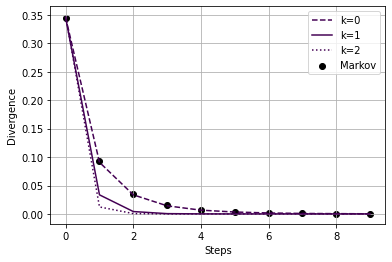

In [ ]:
style = ["--", "-", ":"]
plt.scatter((N*(n+1)*0+1)*np.arange(len(d)), markov_divs, color = "black", label = "Markov", alpha = 1)
for i, all_divergences in enumerate(complete_divergences):
    for n,d in enumerate(all_divergences):
        plt.plot((N*(n+1)*0+1)*np.arange(len(d)), d, color=plt.cm.viridis(i / len(complete_divergences)), label=f'k={n}', ls = style[n])
plt.xlabel('Steps')
plt.ylabel('Divergence')
plt.legend()
plt.grid(True)
#plt.xlim(0,200)
#plt.yscale("log")

In [61]:
N = 500
beta = 1
beta_target = 1 + 1/np.sqrt(N)

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta
delta_percentage = 0.00  # Define the delta percentage
W = W * (1 - delta_percentage)  # Subtract the delta percentage from each element

In [62]:
all_markov = []
ks = [0,1,2,5,10]
probMADE = compute_Pm_abs(N, W)
target_Pm = torch.tensor(get_exact_distribution(N, beta_target)).cuda()
exact = torch.tensor(get_exact_distribution(N, 1)).cuda()
for k in tqdm(ks):
    start_Pm = torch.clone(exact)
    matrix = torch.tensor(get_matrix_mixed(N, beta_target, W, k)).cuda()
    #ones = torch.ones_like(target_Pm)
    #ones /= ones.sum()
    #start_Pm = ones
    markov_divs = []
    for i in range(100):
        divergence = compute_chi2_divergence(start_Pm, target_Pm)
        markov_divs.append(divergence.item())
        #print(f"Step {i}, Chi^2 divergence: {divergence.item()}")
        start_Pm = torch.matmul(matrix.float().T, start_Pm.float())
    all_markov.append(markov_divs)


100%|██████████| 5/5 [00:33<00:00,  6.68s/it]


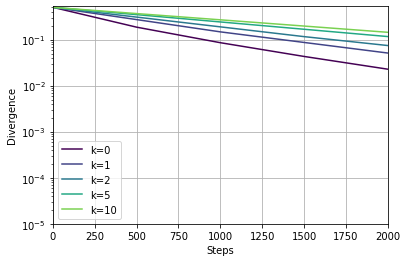

In [63]:
style = ["-", "-", ":"]
for i, d in enumerate(all_markov):
    plt.plot((N*(ks[i]+1)*1+0)*np.arange(len(d)), d, color=plt.cm.viridis(i / len(all_markov)), label=f'k={ks[i]}')
plt.xlabel('Steps')
plt.ylabel('Divergence')
plt.legend()
plt.grid(True)
plt.xlim(0,2000)
plt.ylim(10**-5)
#plt.xlim(0,100*N)
plt.yscale("log")

In [ ]:
k = 1
# Compute initial distributions and matrix
probMADE = compute_Pm_abs(N, W)
start_Pm = torch.tensor(get_exact_distribution(N, 1)).cuda()
target_Pm = torch.tensor(get_exact_distribution(N, beta_target)).cuda()
matrix = torch.tensor(get_matrix_mixed(N, beta_target, W, k)).cuda()

# Compute initial divergence and set the target divergence to 37% of the initial value
divergence0 = compute_chi2_divergence(start_Pm, target_Pm).item()
markov_divs = [divergence0]
target_value = 0.37 * divergence0
print(f"Step 0, Chi^2 divergence: {divergence0}")

exact_iter = None
max_steps = 10

# Iterate and update the distribution
for i in range(1, max_steps):
    # Store the previous divergence value for interpolation
    prev_div = markov_divs[-1]
    
    # Update the distribution
    start_Pm = torch.matmul(matrix.float().T, start_Pm.float())
    
    # Compute the current divergence
    curr_div = compute_chi2_divergence(start_Pm, target_Pm).item()
    markov_divs.append(curr_div)
    print(f"Step {i}, Chi^2 divergence: {curr_div}")
    
    # Check if we've reached or passed the target divergence
    if curr_div <= target_value:
        # Perform linear interpolation between the previous and current steps.
        # We assume divergence decreases roughly linearly between the two steps.
        alpha = (target_value - prev_div) / (curr_div - prev_div)
        exact_iter = (i - 1) + alpha
        print(f"Target divergence reached at iteration: {exact_iter*N*(k+1):.3f}")
        break


Step 0, Chi^2 divergence: 5.3493218421936035
Step 1, Chi^2 divergence: 2.178907632827759
Step 2, Chi^2 divergence: 1.1281918287277222
Target divergence reached at iteration: 1190.021


In [ ]:
# autovalore più grande?
# studio sistematico dei vari regimi per vari N?
#annealing in temperatura?
#partendo random fai meglio???
#analisi di adam?

In [42]:
N = 100
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

probMADE = compute_Pm_abs(N, W)

In [43]:
N = 100
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

probMADE = compute_Pm_abs(N, W)

In [17]:
def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = np.linalg.matrix_power(Tlocal, N*k).dot(Tmade)
    return T

In [22]:
beta_target = 1.2
nmax = 6
P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
P = torch.eye(P.shape[0])-P
P_inv = torch.linalg.inv(P)
result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))
print(result)

tensor([1.2772, 1.2772, 1.2772, 1.2772, 1.2772, 1.2772], dtype=torch.float64)


In [23]:
cumulative = probMADE[nmax:].sum()
fpt_made = 1/cumulative
print(fpt_made)

tensor(1.2772, device='cuda:1', dtype=torch.float64)


In [11]:
def get_beta(m):
    return np.arctanh(m)/m

In [93]:
N = 1000
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")[:,1]]) #Need to add the starting 0
W *= beta

probMADE = compute_Pm_abs(N, W)

In [96]:
Ns = [1000]
steps = [32]

for i, N in enumerate(Ns):
    beta = 1

    results = []
    for mtarget in np.arange(2,0.4*N,steps[i])/N:
        beta_target = get_beta(mtarget)
        nmax = int((1+mtarget)*N/4)

        P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    #all_results.append(results)

1.0000013333365332 0.002 4533.5774369009905 9086.85498101536 2.0043453779024554
1.0003856008214183 0.034 10763.507618063677 21441.141746579684 1.992021793211392
1.0014558067950547 0.066 25452.137222104167 51209.63692827323 2.0119975183773446
1.003219908198226 0.098 59387.87982723499 116266.36389869236 1.957745658489953
1.0056911540682958 0.13 135350.14939801907 215802.1698936832 1.5943991998049585
1.0088883855857207 0.162 298024.02237701754 702232.6887296384 2.3562955869418927
1.0128364727987604 0.194 626676.0856812554 1414279.6128628196 2.256795249056561
1.0175669090850212 0.226 1243553.1721053647 777440.5500087226 0.6251767656163005
1.023118593203499 0.258 2301802.108803354 1250642.582571946 0.5433319301380438
1.0295388402075116 0.29 4696129.63940671 875193.7029027953 0.1863648940946536
1.0368846777503664 0.322 13718671.638698166 1033073.6393863788 0.07530420339475465
1.0452245052113254 0.354 49922010.17984666 1332184.2364931686 0.02668530837788593
1.0546402222832982 0.386 224659944.

In [62]:
def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = Tmade.dot(np.linalg.matrix_power(Tlocal, k*N))
    return T

In [32]:

all_results = []
Ns = [20,50,100, 200, 350, 500, 700]
steps = [2, 4, 4, 8, 12, 16, 32]

Ns = [350]
steps = [12]

for i, N in enumerate(Ns):
    beta = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    probMADE = compute_Pm_abs(N, W)

    results = []
    for mtarget in np.arange(2,0.9*N,steps[i])/N:
        beta_target = get_beta(mtarget)
        nmax = int((mtarget)*N/2)

        P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

1.000010884566991 0.005714285714285714 1.0166764537680282 2.0161705533592125 1.9830994864559297
1.0005338459192052 0.04 1.1280735018475474 2.2317635987659616 1.9783849147336603
1.001845570368227 0.07428571428571429 1.2640391773362278 2.493011820237255 1.972258348424692
1.0039572780898274 0.10857142857142857 1.4323655153721728 2.811092544652279 1.9625525150414351
1.0068872535812332 0.14285714285714285 1.6444549377250735 3.2024046651316422 1.9473958158815983
1.0106613243931706 0.17714285714285713 1.86577070825518 3.5966439098302807 1.9276987755873647
1.0153135562850184 0.21142857142857144 2.275330730110368 4.3040634288451 1.891621016623076
1.0208872039008803 0.24571428571428572 2.7571790549094244 5.082497690959841 1.843368743828937
1.0274359730420748 0.28 3.4218871878189265 6.06916508918341 1.77363096912959
1.0350256734063739 0.3142857142857143 4.365618272758649 7.310625713442283 1.67459114761829
1.0437363722167627 0.3485714285714286 5.751749759515667 8.846192030967535 1.538000156618851


(0.0, 0.15)

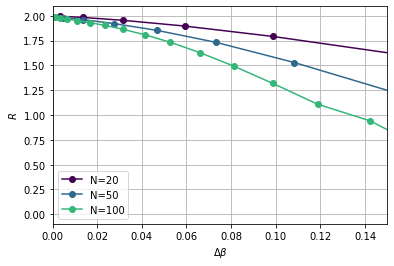

In [31]:
Ns = [20,50,100, 200, 350, 500, 700, 1000][:]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results[:]):
    results = np.array(results)
    plt.plot((results[:,0]-1), results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results[:])), label=f'N={Ns[i]}')
    plt.legend()
    plt.xlabel(r'$\Delta \beta$')
    plt.ylabel(r'$R$')
    plt.grid(True)
plt.xlim(0,0.15)
#plt.ylim(1.8, 2.01)

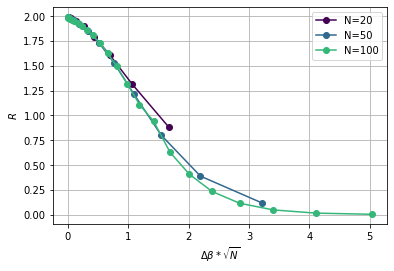

In [30]:
Ns = [20,50,100, 200, 350, 500, 700, 1000][:]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results[:]):
    results = np.array(results)
    plt.plot((results[:,0]-1)*Ns[i]**0.5, results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results[:])), label=f'N={Ns[i]}')
    plt.xlabel(r'$\Delta \beta*\sqrt{N}$')
    plt.ylabel(r'$R$')
    plt.grid(True)
#plt.axvline(x=0.5, color='black', linestyle='--', label = r'$\Delta \beta \sqrt{N} = 0.5$')
plt.legend()
#plt.xlim(0,0.4)

In [38]:
N = 500

mtarget = np.arange(2,0.9*N,steps[i])[3]/N
beta_target = get_beta(mtarget)
nmax = int((1+mtarget)*N/4)

get_matrix_mixed(N, beta_target, W, k=N)[:nmax, :nmax]

array([[0.0062464 , 0.01249268, 0.01249232, ..., 0.00078113, 0.00070891,
        0.00064164],
       [0.00624586, 0.01249161, 0.01249125, ..., 0.00078108, 0.00070887,
        0.0006416 ],
       [0.00624425, 0.01248839, 0.01248804, ..., 0.00078094, 0.00070873,
        0.00064148],
       ...,
       [0.00582969, 0.01165887, 0.01165738, ..., 0.00093165, 0.00084983,
        0.00077268],
       [0.00585734, 0.01171415, 0.01171258, ..., 0.00094442, 0.00086213,
        0.00078442],
       [0.0058843 , 0.01176804, 0.0117664 , ..., 0.00095713, 0.00087442,
        0.0007962 ]])

In [156]:
plt.scatter(np.array(all_results[2])[:,0], np.array(all_results[])[:,-1])

SyntaxError: invalid syntax (<ipython-input-156-a4f16f13504d>, line 1)

In [14]:
def get_beta(m):
    return np.arctanh(m)/m

In [13]:
N = 100
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

probMADE = compute_Pm_abs(N, W)

In [10]:
from scipy.optimize import fsolve
import numpy as np

def mhat(beta):
    """
    Solves the equation m = tanh(beta * m) for m as a function of beta.

    Parameters:
    - beta (float): The value of beta.

    Returns:
    - float: The solution for m.
    """
    # Define the self-consistent equation
    def self_consistent_eq(m):
        return m - np.tanh(beta * m)
    
    # Initial guess for m
    m_initial = 0.5
    
    # Solve the equation using fsolve
    m_solution = fsolve(self_consistent_eq, m_initial)
    
    return m_solution[0]

In [109]:
all_results = []

coefficients = [0.05,0.01, 0.05, 0.1, 0.5,1]

for coeff in coefficients:
    results = []

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((1+mtarget)*N/4)

    for pert in np.linspace(0,0.3,20):
        
        Wpert = W * (1 - pert)

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

0.0 1.005 0.12192611348882793 11.12364090637479 21.492291098504587 1.9321273744271699
0.015789473684210527 1.005 0.12192611348882793 11.772060779977723 22.075411847688596 1.875237671660269
0.031578947368421054 1.005 0.12192611348882793 12.746767079209974 22.950654758646497 1.8005078947491795
0.04736842105263158 1.005 0.12192611348882793 14.018417978528673 24.02321509041771 1.7136894567712917
0.06315789473684211 1.005 0.12192611348882793 15.545015159162494 25.187998153105596 1.620326380850093
0.07894736842105263 1.005 0.12192611348882793 17.31716211978273 26.387930285334768 1.5238022317288236
0.09473684210526316 1.005 0.12192611348882793 19.366148426588985 27.60643876515864 1.4254996996334102
0.1105263157894737 1.005 0.12192611348882793 21.742766791423232 28.836904609428874 1.326275762696587
0.12631578947368421 1.005 0.12192611348882793 24.509405605261584 30.072793193131506 1.226989902467304
0.14210526315789473 1.005 0.12192611348882793 27.742042630953446 31.307256112628703 1.1285130128

Text(0.5, 1.0, '$N = 100$')

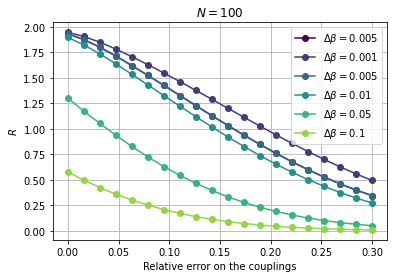

In [114]:
#Ns = [20,50,100, 200, 500]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0]), results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=rf'$\Delta \beta = {coefficients[i]/np.sqrt(N)}$')
plt.legend()
plt.xlabel(r'Relative error on the couplings')
plt.ylabel(r'$R$')
plt.grid(True)
plt.title(fr"$N = {N}$")
#plt.xlim(1,1.2)

In [45]:
all_results = []

coeff = 0.5
Ns = [20,50,100,200,350, 500, 700]

for i, N in enumerate(Ns):
    results = []

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    for pert in np.linspace(0,0.3,10):
        
        Wpert = W * (1 - pert)

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

0.0 1.1118033988749896 0.5267722209710917 2.205422022302157 3.9041390954133544 1.7702458105220018
0.03333333333333333 1.1118033988749896 0.5267722209710917 2.302463690335264 3.9807196015493855 1.7288957121272774
0.06666666666666667 1.1118033988749896 0.5267722209710917 2.408807404954742 4.058938546341131 1.6850407126747404
0.1 1.1118033988749896 0.5267722209710917 2.5255153957720946 4.1386134516577116 1.6387203414344913
0.13333333333333333 1.1118033988749896 0.5267722209710917 2.6537902407982976 4.219537701842834 1.590004227528374
0.16666666666666666 1.1118033988749896 0.5267722209710917 2.794995513888182 4.30148150902585 1.5389940655188963
0.2 1.1118033988749896 0.5267722209710917 2.95067969954838 4.384193533332165 1.4858249555189582
0.23333333333333334 1.1118033988749896 0.5267722209710917 3.1226039156776277 4.4674031857425796 1.430665978260365
0.26666666666666666 1.1118033988749896 0.5267722209710917 3.3127740760293367 4.550823613381839 1.373719882170902
0.3 1.1118033988749896 0.526

Text(0.5, 1.0, '$\\Delta \\beta = 0.5/\\sqrt{N}$')

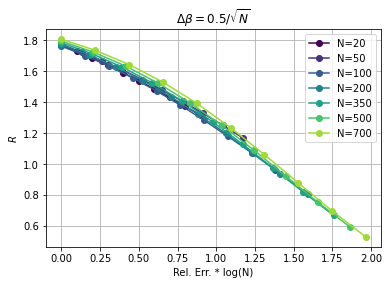

In [64]:
Ns = [20,50,100,200,350, 500, 700]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0])*np.log(Ns[i]), results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
plt.legend()
plt.xlabel(r'Rel. Err. * log(N)')
plt.ylabel(r'$R$')
plt.grid(True)
#plt.xlim(0,0.1)
#plt.yscale("log")
#plt.xscale("log")
plt.title(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")


In [16]:
all_results = []

coeff = 0.01
Ns = [500]

for i, N in enumerate(Ns):
    results = []

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((1+mtarget)*N/4)

    for pert in np.linspace(0,0.3,1):
        pert = 0.03
        Wpert = W * (1 - pert)

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))

0.03 1.0004472135955 0.03661367899943011 253.36672537451892 504.8006749286305 1.9923716272626155


Cutoffed value

In [82]:
all_results = []

coeff = 0.5
Ns = [20,50,100, 200, 350, 500,700]

for i, N in enumerate(Ns):
    results = []

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    for cutoff in np.linspace(0,W.max(),10)[::-1]:
        
        Wpert = np.copy(W)
        Wpert[Wpert < cutoff] = 0

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(cutoff/W.max(), cutoff, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((cutoff/W.max(), cutoff, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

1.0 0.2132783830218845 1.1118033988749896 0.5267722209710917 22.937498958486955 5.917887517278101 0.25800055742731537
0.888888888888889 0.1895807849083418 1.1118033988749896 0.5267722209710917 22.937498958486955 5.917887517278101 0.25800055742731537
0.7777777777777778 0.16588318679479908 1.1118033988749896 0.5267722209710917 20.8284447192894 5.888521817369288 0.2827153873815589
0.6666666666666667 0.14218558868125636 1.1118033988749896 0.5267722209710917 18.27800468770648 5.844693244622375 0.3197664813245961
0.5555555555555556 0.11848799056771361 1.1118033988749896 0.5267722209710917 13.222759714639276 5.714023563914348 0.43213547604500424
0.4444444444444445 0.0947903924541709 1.1118033988749896 0.5267722209710917 9.257500152007331 5.527548016005551 0.5970886227646451
0.33333333333333337 0.07109279434062818 1.1118033988749896 0.5267722209710917 4.143938449840064 4.8708434867358275 1.17541405252383
0.22222222222222224 0.04739519622708545 1.1118033988749896 0.5267722209710917 2.2054220223

IndexError: list index out of range

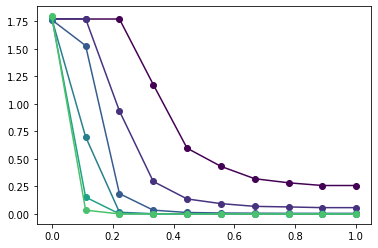

In [83]:
Ns = [20,50,100, 200, 500, 1000]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0]), results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
plt.legend()
plt.xlabel(r'Relative error on the couplings')
plt.ylabel(r'$R$')
plt.grid(True)
#plt.xlim(0,0.1)
#plt.yscale("log")
#plt.xscale("log")
plt.title(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")

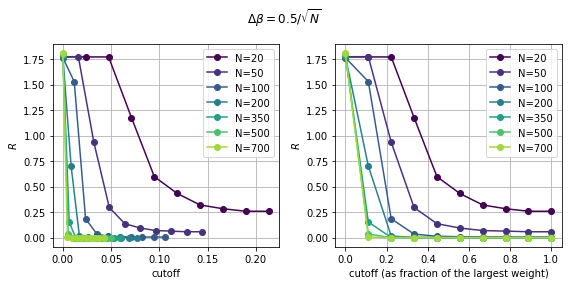

In [84]:
Ns = [20, 50, 100, 200, 350, 500, 700]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i, results in enumerate(all_results):
    results = np.array(results)
    # Left subplot: x = results[:,1]
    axs[0].plot(results[:, 1], results[:, -1], marker="o", alpha=1,
                color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
    # Right subplot: x = results[:,0]
    axs[1].plot(results[:, 0], results[:, -1], marker="o", alpha=1,
                color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')

# Customize left subplot
axs[0].set_xlabel("cutoff")
axs[0].set_ylabel(r'$R$')
axs[0].grid(True)
axs[0].legend()

# Customize right subplot
axs[1].set_xlabel("cutoff (as fraction of the largest weight)")
axs[1].set_ylabel(r'$R$')
axs[1].grid(True)
axs[1].legend()

fig.suptitle(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")
plt.tight_layout()
plt.show()


In [40]:
beta = 1
N = 100

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

cutoff = W.max()*0.6
Wpert = np.minimum(W, cutoff)

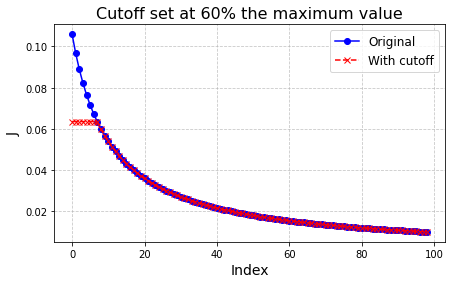

In [50]:
import matplotlib.pyplot as plt

# Plot W and Wpert
plt.figure(figsize=(7, 4))
plt.plot(W[1:], label='Original', marker='o', linestyle='-', color='b')
plt.plot(Wpert[1:], label='With cutoff', marker='x', linestyle='--', color='r')

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('J', fontsize=14)
plt.title('Cutoff set at 60% the maximum value', fontsize=16)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Show plot
plt.show()

train_made

In [15]:
N = 100
beta = 1
pop_size = 50000
num_sweeps = 30
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)


W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model_exact = setup_model(W, N = N)

In [ ]:
num_epochs = 1001
lr = 1
model, weights  = train_different_epochs(pop[:50000], N, model_exact.layer.weight, [0,10,25, 50, 100, 200, 500, 1000], start = "zero", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=50000)

 17%|█▋        | 175/1001 [00:06<00:32, 25.75it/s]


KeyboardInterrupt: 

In [112]:
weights = np.array(weights)

IndexError: index 100 is out of bounds for axis 1 with size 100

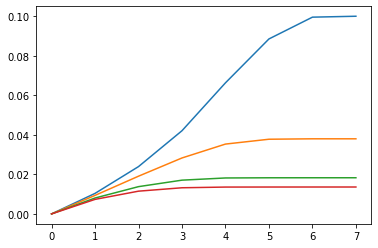

In [113]:
for i in [2,20,50,70,100,140,190]:
    plt.plot(weights[:,i])
plt.show()

In [55]:
res = model.layer.weight.sum(1)
res[1:]/= torch.arange(1, len(res), device = "cuda")

In [109]:
all_results = []

coeff = 0.5
Ns = [20,50,100,200,350, 500, 700]
Ns = [200]

for i, N in enumerate(Ns):
    results = []

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    for Wpert in weights:

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((pert, beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

0.1 1.0353553390593273 0.3156711724359867 72163.34361198152 53.44464193800398 0.0007406065082761824
0.1 1.0353553390593273 0.3156711724359867 561.8493397952892 34.25704611481299 0.06097194334569228
0.1 1.0353553390593273 0.3156711724359867 41.937486882550125 19.7790041979908 0.471630650004941
0.1 1.0353553390593273 0.3156711724359867 10.637627269149737 11.757367766459181 1.1052622421314584
0.1 1.0353553390593273 0.3156711724359867 5.073481535723416 7.867186121190309 1.5506484188019312
0.1 1.0353553390593273 0.3156711724359867 3.613328706746264 6.292696843531324 1.741523496542827
0.1 1.0353553390593273 0.3156711724359867 3.144568892782719 5.696694481372079 1.8115979250595815
0.1 1.0353553390593273 0.3156711724359867 3.1031716391557014 5.641463112432959 1.8179668314988422


In [223]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]

times = [0,10,25, 50, 100, 200, 500, 1000]

num_epochs = 1001
for i, N in enumerate(Ns):
    results = []
    lr = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)
    pop = montecarlo_CW(N, beta, pop_size, num_sweeps)
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "random", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=1000000, scheduler_time = 100000, batch_size=pop_size)

    for count, Wpert in enumerate(weights):

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

100%|██████████| 1001/1001 [00:38<00:00, 26.05it/s]


0 1.1118033988749896 0.5267722209710917 48.40722032346301 6.081243237954542 0.1256267804124865
10 1.1118033988749896 0.5267722209710917 3.7396439890847435 4.710824013450103 1.259698524030639
25 1.1118033988749896 0.5267722209710917 2.467464141216712 4.097771969372331 1.6607219942623805
50 1.1118033988749896 0.5267722209710917 2.2524538303497175 3.940899505224575 1.749602789688572
100 1.1118033988749896 0.5267722209710917 2.216174792377361 3.9125861265506914 1.7654682022411852
200 1.1118033988749896 0.5267722209710917 2.2138143064604567 3.910720234180818 1.7665077973199337
500 1.1118033988749896 0.5267722209710917 2.2138010972017845 3.910709722411836 1.7665135893892734
1000 1.1118033988749896 0.5267722209710917 2.2138010972017845 3.910709722411836 1.7665135893892734


100%|██████████| 1001/1001 [00:38<00:00, 25.94it/s]


0 1.0707106781186548 0.43321638618915215 153.85018019078174 8.424546355338045 0.0547581182218389
10 1.0707106781186548 0.43321638618915215 8.457846365989319 6.734747004902914 0.7962720902551116
25 1.0707106781186548 0.43321638618915215 3.679093175315325 5.289701947555926 1.437773303227788
50 1.0707106781186548 0.43321638618915215 2.761405072282682 4.637907572249236 1.6795462638936076
100 1.0707106781186548 0.43321638618915215 2.514526702563879 4.413639465395365 1.755256550226768
200 1.0707106781186548 0.43321638618915215 2.4649900028907648 4.366087246679742 1.7712393322323845
500 1.0707106781186548 0.43321638618915215 2.4597159421140797 4.360931478440963 1.7729410960734044
1000 1.0707106781186548 0.43321638618915215 2.4597055873139326 4.360921096982189 1.7729443391411883


100%|██████████| 1001/1001 [00:38<00:00, 25.85it/s]


0 1.05 0.37070573256992784 8063.558323066641 12.428157047852949 0.0015412745279340168
10 1.05 0.37070573256992784 58.985826939983276 10.99159172901761 0.18634292844959693
25 1.05 0.37070573256992784 8.788584250283625 8.222595758608882 0.935599582872921
50 1.05 0.37070573256992784 4.169171869543336 6.213600259508134 1.49036798048547
100 1.05 0.37070573256992784 3.1436617609679574 5.344589634891374 1.7001159925187799
200 1.05 0.37070573256992784 2.9357838555135056 5.133116631005624 1.748465446925001
500 1.05 0.37070573256992784 2.899548369309431 5.095357784738657 1.7572935973998565
1000 1.05 0.37070573256992784 2.8982283070480257 5.093946447453892 1.7576070301522595


100%|██████████| 1001/1001 [00:38<00:00, 26.00it/s]
/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


0 1.0353553390593273 0.3156711724359867 195194.76065527662 16.710722982610196 8.561050986466865e-05
10 1.0353553390593273 0.3156711724359867 698.3318149503857 15.67461753344845 0.02244580183499456
25 1.0353553390593273 0.3156711724359867 35.08200522421429 12.880680043141528 0.3671591735084467
50 1.0353553390593273 0.3156711724359867 8.197031289488946 9.084228598456304 1.1082339785752693
100 1.0353553390593273 0.3156711724359867 4.184435702264731 6.6290539645797395 1.5842169497291865
200 1.0353553390593273 0.3156711724359867 3.321434165938166 5.758523412119824 1.7337460640269178
500 1.0353553390593273 0.3156711724359867 3.1354896739050404 5.547256515096405 1.7691834743591013
1000 1.0353553390593273 0.3156711724359867 3.1174030811557603 5.52619562139174 1.7726920380610303


100%|██████████| 1001/1001 [00:38<00:00, 26.01it/s]


0 1.0267261241912424 0.27652547186691834 2123334.362559589 21.223240993519948 9.995242090810528e-06
10 1.0267261241912424 0.27652547186691834 8012.8301733882 20.39809006907708 0.002545678571451841
25 1.0267261241912424 0.27652547186691834 198.1819794183995 18.19370464522133 0.09180302214466732
50 1.0267261241912424 0.27652547186691834 22.07363502073653 13.666858290314602 0.6191485125796278
100 1.0267261241912424 0.27652547186691834 6.691925166838561 8.981946288672662 1.3422066243630704
200 1.0267261241912424 0.27652547186691834 4.051348929313979 6.75817219700435 1.6681288911218817
500 1.0267261241912424 0.27652547186691834 3.3715650689853462 5.974779926034412 1.7721087399426902
1000 1.0267261241912424 0.27652547186691834 3.301213634329104 5.888318971317339 1.7836831006891214


100%|██████████| 1001/1001 [00:38<00:00, 26.07it/s]


0 1.022360679774998 0.2539045057902792 94887728.16205277 24.63081075749364 2.5957846430286784e-07
10 1.022360679774998 0.2539045057902792 181345.37874939456 24.044088153064326 0.00013258726700883522
25 1.022360679774998 0.2539045057902792 1625.7369884978668 22.48786896874766 0.013832415161769671
50 1.022360679774998 0.2539045057902792 70.70536932936022 18.391365604263054 0.26011271532423896
100 1.022360679774998 0.2539045057902792 11.248639121610314 11.824412260210524 1.0511860263606523
200 1.022360679774998 0.2539045057902792 5.011285620830935 7.894157980164924 1.575276002499329
500 1.022360679774998 0.2539045057902792 3.57807299564324 6.313462758705658 1.7644868526698878
1000 1.022360679774998 0.2539045057902792 3.40752516542998 6.097075329989288 1.7892972271622023


100%|██████████| 1001/1001 [00:38<00:00, 26.00it/s]


0 1.0188982236504613 0.2341322682996002 3107542314.303655 28.066096709459938 9.031605645488708e-09
10 1.0188982236504613 0.2341322682996002 3800047.597042747 27.60290107921446 7.263830353255429e-06
25 1.0188982236504613 0.2341322682996002 15046.894919596136 26.418761925592598 0.0017557617080974264
50 1.0188982236504613 0.2341322682996002 267.6401596679876 23.043191122477925 0.08609765870362436
100 1.0188982236504613 0.2341322682996002 21.159044224336157 15.508625318347807 0.7329549082614281
200 1.0188982236504613 0.2341322682996002 6.584184181725838 9.493041189044478 1.4417945985460225
500 1.0188982236504613 0.2341322682996002 3.8495582500521346 6.729485448070021 1.7481188777904277
1000 1.0188982236504613 0.2341322682996002 3.4772710936568467 6.247644452588355 1.7967090526778762


In [211]:
data

array([[[0, 1.1118033988749896, 0.5267722209710917, 24.160737327188933,
         5.932666388978138, 0.24554988983311773],
        [10, 1.1118033988749896, 0.5267722209710917, 3.575452281799512,
         4.651684100364823, 1.3010057843713263],
        [25, 1.1118033988749896, 0.5267722209710917, 2.4744033075305314,
         4.102584424420898, 1.6580095944485704],
        [50, 1.1118033988749896, 0.5267722209710917, 2.247772740132683,
         3.937663260161318, 1.7518066617041022],
        [100, 1.1118033988749896, 0.5267722209710917, 2.207299250386216,
         3.905699237443476, 1.7694470909461355],
        [200, 1.1118033988749896, 0.5267722209710917, 2.205203554376105,
         3.904025819194827, 1.7703698198052977],
        [500, 1.1118033988749896, 0.5267722209710917, 2.205193835292875,
         3.9040180800506428, 1.7703741129550838],
        [1000, 1.1118033988749896, 0.5267722209710917,
         2.205193907755434, 3.9040181321200467, 1.7703740783928468]],

       [[0, 1.0707106

In [ ]:
#import numpy as np

# Save all_results to a text file
#np.save("data_training_empirical_randominitialization.npy", np.array(all_results, dtype=object))

Text(0.5, 1.0, '$\\Delta \\beta = 0.5/\\sqrt{N}$')

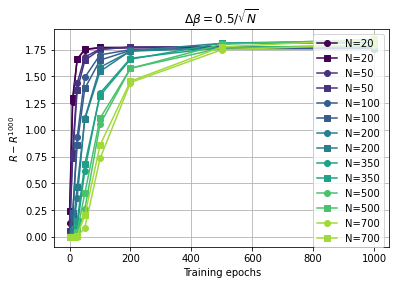

In [224]:
Ns = [20,50,100,200,350, 500, 700]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0]), results[:,-1]-results[-1,-1]*0, marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
    plt.plot((data[i][:,0]), data[i][:,-1]-data[i][-1,-1]*0, marker="s", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
plt.legend()
plt.xlabel(r'Training epochs')
plt.ylabel(r'$R-R^{1000}$')
plt.grid(True)
#plt.xlim(0,0.1)
#plt.yscale("log")
#plt.xscale("log")
plt.title(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")
#plt.ylim(1,2)


Text(0.5, 1.0, '$\\Delta \\beta = 0.5/\\sqrt{N}$')

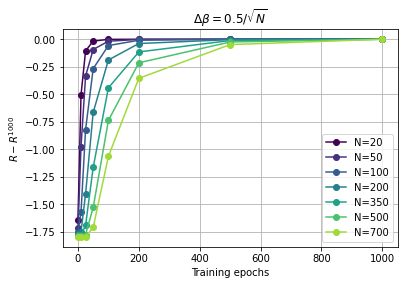

In [225]:
Ns = [20,50,100,200,350, 500, 700]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0]), results[:,-1]-results[-1,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
plt.legend()
plt.xlabel(r'Training epochs')
plt.ylabel(r'$R-R^{1000}$')
plt.grid(True)
#plt.xlim(0,0.1)
#plt.yscale("log")
#plt.xscale("log")
plt.title(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")
#plt.ylim(1,2)


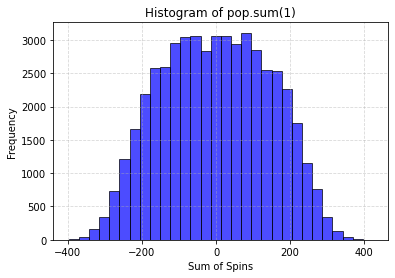

In [41]:
import matplotlib.pyplot as plt

# Compute the sum along axis 1
pop_sum = pop.sum(1)

# Plot the histogram
plt.hist(pop_sum.cpu().numpy(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Sum of Spins')
plt.ylabel('Frequency')
plt.title('Histogram of pop.sum(1)')
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

(0.0, 50.0)

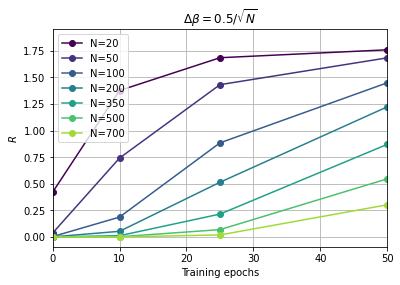

In [37]:
Ns = [20,50,100,200,350, 500, 700]
#all_results = [all_results[i] for i in sorted_indices]

for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot((results[:,0]), results[:,-1], marker="o", alpha=1, color=plt.cm.viridis(i / len(all_results)), label=f'N={Ns[i]}')
plt.legend()
plt.xlabel(r'Training epochs')
plt.ylabel(r'$R$')
plt.grid(True)
#plt.xlim(0,0.1)
#plt.yscale("log")
#plt.xscale("log")
plt.title(rf"$\Delta \beta = {coeff}/\sqrt{{N}}$")
plt.xlim(0,50)


In [73]:
N = 700
beta = 1
coeff = 0.5
pop_size = 50000
num_sweeps = 30

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta
model_exact = setup_model(W, N = N)

beta_target = 1
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

In [74]:
times = [0,10,25, 50, 100, 200, 500, 1000]
num_epochs = 1001
model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=1, patience=1000000, scheduler_time = 100000, batch_size=pop_size)

100%|██████████| 1001/1001 [00:37<00:00, 26.51it/s]


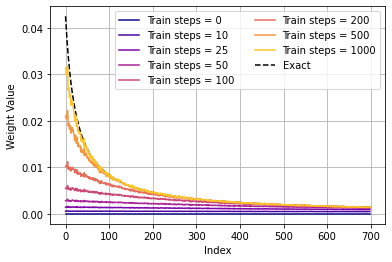

In [75]:
for count, Wpert in enumerate(weights):
    cmap = plt.get_cmap('plasma')
    plt.plot(Wpert[1:], label=f'Train steps = {times[count]}', zorder = 3,color=cmap((count) / len(weights)))
plt.plot(W[1:], label='Exact', color = "black", ls = "--")
plt.xlabel('Index')
plt.ylabel('Weight Value')
#plt.title('Wpert Values Across Iterations')
plt.legend(ncol = 2)
plt.grid(True)
plt.show()

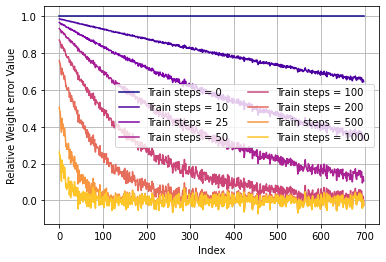

In [76]:
for count, Wpert in enumerate(weights):
    cmap = plt.get_cmap('plasma')
    plt.plot((W[1:]-Wpert[1:])/W[1:], label=f'Train steps = {times[count]}', zorder = 3,color=cmap((count) / len(weights)))

plt.xlabel('Index')
plt.ylabel('Relative Weight error Value')
#plt.title('Wpert Values Across Iterations')
plt.legend(ncol = 2)
plt.grid(True)

plt.show()

Train steps = 0: A = 1.00e+00, B = 78100027837.35
Train steps = 10: A = 9.08e-01, B = 308.40
Train steps = 25: A = 7.83e-01, B = 125.41
Train steps = 50: A = 6.07e-01, B = 64.44
Train steps = 100: A = 3.51e-01, B = 34.68
Train steps = 200: A = 8.19e-02, B = 25.75
Train steps = 500: A = -1.60e-01, B = 4.34
Train steps = 1000: A = -1.71e-01, B = 4.41


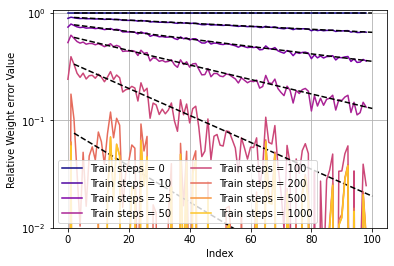

In [65]:
from scipy.optimize import curve_fit

# Initialize lists to store A and lambda parameters
A_params = []
lambdas = []

for count, Wpert in enumerate(weights):
    cmap = plt.get_cmap('plasma')
    plt.plot((W[1:]-Wpert[1:])/W[1:], label=f'Train steps = {times[count]}',color=cmap((count) / len(weights)))
    # Define the exponential function
    def exp_func(x, A, B):
        return A * np.exp(-x / B)
    cmap = plt.get_cmap('plasma')
    relative_error = (W[1:] - Wpert[1:]) / W[1:]
    x_data = np.arange(2, len(W)+1)  # x values (indices)
    y_data = relative_error  # y values (relative error)
    
    # Fit the data
    popt, _ = curve_fit(exp_func, x_data, y_data, p0=(1, 100))
    A, B = popt
    
    # Add the fit to the plot
    plt.plot(x_data, exp_func(x_data, A, B), linestyle='--', color="k")
    
    # Print the parameters
    print(f'Train steps = {times[count]}: A = {A:.2e}, B = {B:.2f}')
    A_params.append(A)
    lambdas.append(B)

A_params = np.array(A_params)
lambdas = np.array(lambdas)
plt.xlabel('Index')
plt.ylabel('Relative Weight error Value')
#plt.title('Wpert Values Across Iterations')
plt.legend(ncol = 2)
plt.grid(True)
plt.yscale("symlog", linthresh=0.001)
plt.ylim(0.01, 1.05)
plt.show()

/home/delbono/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Train steps = 0: A = 1.00e+00, B = 113032404733.11
Train steps = 10: A = 9.05e-01, B = 308.40
Train steps = 25: A = 7.77e-01, B = 125.41
Train steps = 50: A = 5.98e-01, B = 64.44
Train steps = 100: A = 3.41e-01, B = 34.68
Train steps = 200: A = 7.88e-02, B = 25.75
Train steps = 500: A = -1.27e-01, B = 4.34
Train steps = 1000: A = -1.36e-01, B = 4.41


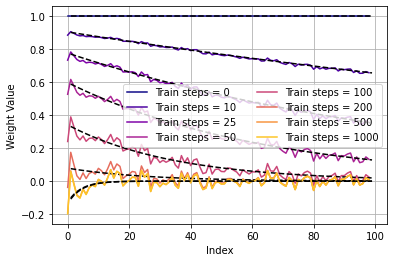

In [66]:
from scipy.optimize import curve_fit

# Initialize lists to store A and lambda parameters
A_params = []
lambdas = []

for count, Wpert in enumerate(weights):
    cmap = plt.get_cmap('plasma')
    plt.plot((W[1:]-Wpert[1:])/W[1:], label=f'Train steps = {times[count]}',color=cmap((count) / len(weights)))
    # Define the exponential function
    def exp_func(x, A, B):
        return A * np.exp(-x / B)
    cmap = plt.get_cmap('plasma')
    relative_error = (W[1:] - Wpert[1:]) / W[1:]
    x_data = np.arange(1, len(W))  # x values (indices)
    y_data = relative_error  # y values (relative error)
    
    # Fit the data
    popt, _ = curve_fit(exp_func, x_data, y_data, p0=(1, 100))
    A, B = popt
    
    # Add the fit to the plot
    plt.plot(x_data, exp_func(x_data, A, B), linestyle='--', color="k")
    
    # Print the parameters
    print(f'Train steps = {times[count]}: A = {A:.2e}, B = {B:.2f}')
    A_params.append(A)
    lambdas.append(B)

A_params = np.array(A_params)
lambdas = np.array(lambdas)
plt.xlabel('Index')
plt.ylabel('Weight Value')
#plt.title('Wpert Values Across Iterations')
plt.legend(ncol = 2)
plt.grid(True)
#plt.yscale("symlog", linthresh=0.001)
#plt.ylim(0.01)
plt.show()

In [1]:
plt.scatter(times[1:], A_params[1:], label='A')

NameError: name 'plt' is not defined

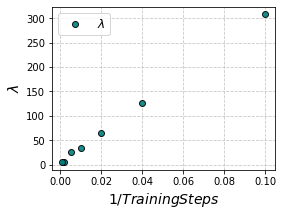

In [67]:
plt.figure(figsize=(4, 3))
plt.scatter(1/np.array(times[1:]), lambdas[1:], label=r'$\lambda$', color='teal', edgecolor='black', alpha=0.9, zorder = 3)

# Add labels and title
plt.xlabel(r'$1/Training Steps$', fontsize=14)
plt.ylabel(r'$\lambda$', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Show plot
plt.show()

In [87]:
times

[0, 10, 25, 50, 100, 200, 500, 1000]

In [25]:
import torch

def compute_correlation_pytorch(pop):
    pop_size, N = pop.shape

    # Compute s_i * s_j for all pairs in a batch-wise manner
    correlation_matrix = torch.bmm(pop.unsqueeze(2), pop.unsqueeze(1))  # Outer product for each configuration

    # Remove diagonal elements by setting them to zero
    correlation_matrix = correlation_matrix - torch.diag_embed(torch.diagonal(correlation_matrix, dim1=1, dim2=2))

    # Sum over all pairs (excluding diagonal) and normalize
    correlation = correlation_matrix.sum(dim=(1, 2)) / (N * (N - 1))

    # Average over all configurations
    return correlation.mean()


In [39]:
N = 700
beta = 1
coeff = 0.5
pop_size = 50000
num_sweeps = 30

beta_target = 1
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)
pop2 = montecarlo_CW(2*N, beta, pop_size, num_sweeps)


In [44]:
cov_matrix = torch.cov(pop2.T)
N = 1400
# Remove diagonal elements
off_diagonal = cov_matrix - torch.diag_embed(torch.diagonal(cov_matrix))
# Compute the average of the off-diagonal elements
average_off_diagonal = off_diagonal.sum() / (N * (N - 1))
average_off_diagonal

tensor(0.0294, device='cuda:0')

In [40]:
compute_correlation_pytorch(pop)

RuntimeError: CUDA out of memory. Tried to allocate 91.27 GiB (GPU 0; 31.75 GiB total capacity; 687.25 MiB already allocated; 28.14 GiB free; 2.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
compute_correlation_pytorch(pop2)

tensor(0.0763, device='cuda:0')

In [ ]:
num_epochs = 1000
lr = 1
times = np.arange(0,num_epochs+1)
model, weights  = train_different_epochs(pop[:50000], N, model_exact.layer.weight, times, start = "optimal", pert_type="uniform_small", epochs = num_epochs, learning_rate=lr, patience=10000, scheduler_time = 1000, batch_size=50000)

100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]


Text(0, 0.5, '$\\Delta J / J$')

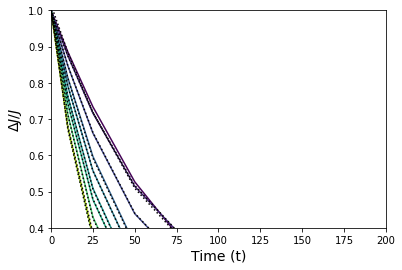

In [70]:
for n in np.arange(1,100,10):
    par = np.array(weights)[:,n]
    cmap = plt.get_cmap('viridis')
    plt.plot(times, np.abs((-par + W[n])) / W[n], color=cmap(n / 100))

from scipy.optimize import curve_fit
TAUS = []
for n in np.arange(1,100,10):
    par = np.array(weights)[:,n]
    cmap = plt.get_cmap('viridis')
    mask = np.array(times) < 400
    fit_times = np.array(times)[mask]
    fit_values = np.abs((-par + W[n])) / W[n]
    fit_values = fit_values[mask]

    # Define the exponential function
    def exp_func(t, A, tau):
        return A * np.exp(-t / tau)

    # Fit the data
    popt, _ = curve_fit(exp_func, fit_times, fit_values, p0=(1, 100))
    A, tau = popt
    TAUS.append(tau)

    # Plot the fit
    plt.plot(fit_times, exp_func(fit_times, A, tau), linestyle=':', color='black', label=f'n={n}, tau={tau:.2f}')

plt.xlim(0,200)
plt.ylim(0.4,1)

plt.xlabel(r'Time (t)', fontsize=14)
plt.ylabel(r'$\Delta J / J$', fontsize=14)

#plt.yscale("log")


[72.48912458149839, 75.97181964153776, 61.034528312708474, 47.48842600053703, 42.66945881354246, 36.718076362169455, 34.055383717333136, 29.303472068472338, 24.98628275946565, 26.216815003394576]
[130.42985881]


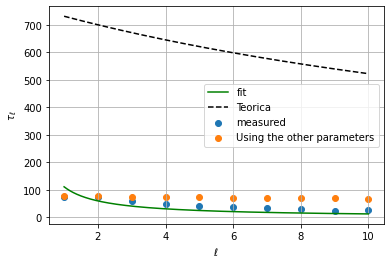

In [71]:
from scipy.optimize import curve_fit

i = -3
print(TAUS)
ls = (np.arange(1,len(TAUS)+1))
plt.scatter(ls, TAUS, label = "measured")
plt.scatter(ls, -times[i]/(np.log(A_params[i])-ls/lambdas[i]), label = "Using the other parameters")

# Define the fitting function
def fit_func(ls, c):
    return 1 / (ls / c + 0.001313)

# Perform the curve fitting
popt, pcov = curve_fit(fit_func, ls, TAUS, p0=(1))

# Extract the fitted parameters
c_fit = popt
print(c_fit)

# Plot the fitted curve
ls_fit = np.linspace(min(ls), max(ls), 500)
TAUS_fit = fit_func(ls_fit, c_fit)
plt.plot(ls_fit, TAUS_fit, color='green', label = "fit")

# Add labels and legend
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\tau_\ell$')
plt.legend()
plt.grid(True)

# Plot the additional curve
plt.plot(ls_fit, 700 / (1 + (ls_fit-2)*0.0425013), linestyle='--', label=r'Teorica', color = "black")
plt.legend()
plt.show()

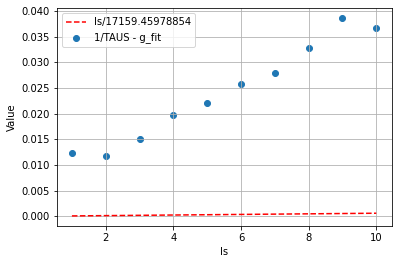

In [72]:
plt.scatter(ls, 1/np.array(TAUS)-g_fit, label='1/TAUS - g_fit')
plt.plot(ls, ls/17159.45978854, label='ls/17159.45978854', color='red', linestyle='--')
plt.xlabel('ls')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
plt.plot(1/(np.arange(1,len(TAUS)+1)), TAUS, "-o")
plt.xlim(0,0.15)


NameError: name 'plt' is not defined

/home/delbono/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


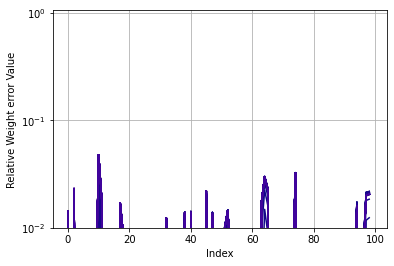

In [50]:
from scipy.optimize import curve_fit

# Initialize lists to store A and lambda parameters
A_params = []
lambdas = []

for count, Wpert in enumerate(weights[::10]):
    cmap = plt.get_cmap('plasma')
    plt.plot((W[1:]-Wpert[1:])/W[1:], label=f'Train steps = {times[count]}',color=cmap((count) / len(weights)))
    # Define the exponential function
    def exp_func(x, A, B):
        return A * np.exp(-x / B)
    cmap = plt.get_cmap('plasma')
    relative_error = (W[1:] - Wpert[1:]) / W[1:]
    x_data = np.arange(1, len(W))  # x values (indices)
    y_data = relative_error  # y values (relative error)
    
    # Fit the data
    popt, _ = curve_fit(exp_func, x_data, y_data, p0=(1, 100))
    A, B = popt
    
    # Add the fit to the plot
    plt.plot(x_data, exp_func(x_data, A, B), linestyle='--', color="k")
    
    # Print the parameters
    #print(f'Train steps = {times[count]}: A = {A:.2e}, B = {B:.2f}')
    A_params.append(A)
    lambdas.append(B)

A_params = np.array(A_params)
lambdas = np.array(lambdas)
plt.xlabel('Index')
plt.ylabel('Relative Weight error Value')
#plt.title('Wpert Values Across Iterations')
#plt.legend(ncol = 2)
plt.grid(True)
plt.yscale("symlog", linthresh=0.001)
plt.ylim(0.01, 1.05)
plt.show()

Exponential fit parameters: A = 1.00e+00, tau = 0.001399


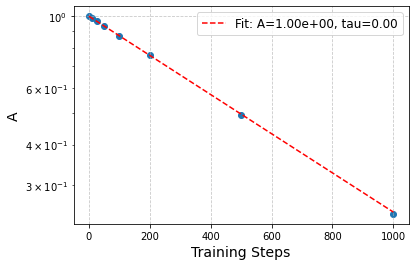

In [60]:
from scipy.optimize import curve_fit

plt.scatter(times,A_params)
# Define the exponential function
def exp_func(t, A, g):
    return A * np.exp(-t*g)

# Exclude the last two points
fit_times = np.array(times[:-2])
fit_A_params = np.array(A_params[:-2])

# Perform the fit
popt, _ = curve_fit(exp_func, fit_times, fit_A_params, p0=(1, 1/100))
A_fit, g_fit = popt

# Plot the fit
fit_curve = exp_func(np.array(times), A_fit, g_fit)
plt.plot(times, fit_curve, label=f'Fit: A={A_fit:.2e}, tau={g_fit:.2f}', linestyle='--', color='red')

# Print the fit parameters
print(f"Exponential fit parameters: A = {A_fit:.2e}, tau = {g_fit:.6f}")


# Add labels and legend
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('A', fontsize=14)
plt.legend(fontsize=12)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)

plt.yscale("log")
plt.show()


In [11]:
from scipy.optimize import curve_fit

Nvalues = [100,200,350,500,700]
all_lambdas = []

for N in Nvalues:
    beta = 1
    coeff = 0.5
    pop_size = 50000
    num_sweeps = 30

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    beta_target = 1
    pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

    times = [0,10,25, 50, 100, 200, 500, 1000]
    num_epochs = 1001
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=1*np.sqrt(N), patience=1000000, scheduler_time = 100000, batch_size=pop_size)

    lambdas = []

    for count, Wpert in enumerate(weights):
        cmap = plt.get_cmap('plasma')        
        # Define the exponential function
        def exp_func(x, A, B):
            return A * np.exp(-x / B)
        cmap = plt.get_cmap('plasma')
        relative_error = (W[1:] - Wpert[1:]) / W[1:]
        x_data = np.arange(2, len(W)+1)  # x values (indices)
        y_data = relative_error  # y values (relative error)
        
        # Fit the data
        popt, _ = curve_fit(exp_func, x_data, y_data, p0=(1, 100))
        A, B = popt
        lambdas.append(B)
    all_lambdas.append(lambdas)


100%|██████████| 1001/1001 [00:37<00:00, 26.47it/s]
/home/delbono/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 1001/1001 [00:37<00:00, 26.41it/s]


In [14]:
data = np.array(all_lambdas)

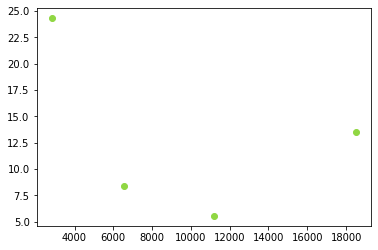

In [19]:
plt.scatter(np.array(Nvalues[1:])**power, data[1:, 3], label=f'Time step {times[i]}', color=cmap(i / 6))

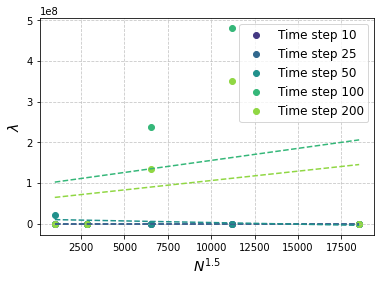

In [16]:
power = 1.5

plt.xlabel(r'$N^{1.5}$', fontsize=14)
plt.ylabel(r'$\lambda$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Use viridis colormap and add legend
cmap = plt.get_cmap('viridis')
for i in range(1, 6):
    plt.scatter(np.array(Nvalues)**power, data[:, i], label=f'Time step {times[i]}', color=cmap(i / 6))
    # Add linear fits for each time step
for i in range(1, 6):
    # Perform linear fit
    coeffs = np.polyfit(np.array(Nvalues)**power, data[:, i], 1)
    linear_fit = np.poly1d(coeffs)
    
    # Plot the linear fit
    plt.plot(np.array(Nvalues)**power, linear_fit(np.array(Nvalues)**power), 
                linestyle='--', color=cmap(i / 6))
plt.legend(fontsize=12)
plt.show()


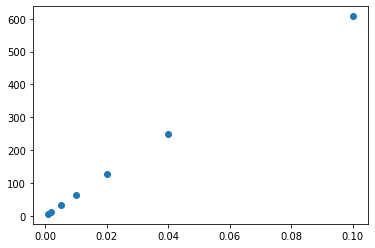

In [107]:
plt.scatter(1/np.array(times[1:]), data[2,1:])


In [16]:
import numpy as np

# Load the data
data = np.load('data_training_empirical_nullinitialization.npy', allow_pickle=True)

In [22]:
data[0]

array([[0, 1.1118033988749896, 0.5267722209710917, 24.160737327188933,
        5.932666388978138, 0.24554988983311773],
       [10, 1.1118033988749896, 0.5267722209710917, 3.575452281799512,
        4.651684100364823, 1.3010057843713263],
       [25, 1.1118033988749896, 0.5267722209710917, 2.4744033075305314,
        4.102584424420898, 1.6580095944485704],
       [50, 1.1118033988749896, 0.5267722209710917, 2.247772740132683,
        3.937663260161318, 1.7518066617041022],
       [100, 1.1118033988749896, 0.5267722209710917, 2.207299250386216,
        3.905699237443476, 1.7694470909461355],
       [200, 1.1118033988749896, 0.5267722209710917, 2.205203554376105,
        3.904025819194827, 1.7703698198052977],
       [500, 1.1118033988749896, 0.5267722209710917, 2.205193835292875,
        3.9040180800506428, 1.7703741129550838],
       [1000, 1.1118033988749896, 0.5267722209710917, 2.205193907755434,
        3.9040181321200467, 1.7703740783928468]], dtype=object)

[20, 50, 100, 200, 350, 500, 700]

In [47]:
colors = ["#A50026", "#D73027", "#F46D43", "#FDAE61", "#FEE090",
          "#E0F3F8", "#ABD9E9", "#74ADD1", "#4575B4", "#313695"]

from matplotlib.colors import LinearSegmentedColormap

# Convert discrete colors to a smooth colormap
smooth_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

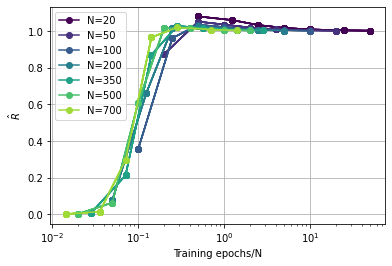

In [82]:
for d in data:
    cmap = plt.get_cmap('viridis')
    for i, d in enumerate(np.array(data)):
        plt.plot(d[1:, 0]/Ns[i]**1, (d[1:, 0] + d[1:, 4]) / (d[1:, 0] + d[1:, 3]), marker="o", color=cmap(i / len(data)))
        #plt.plot(data[i][:, 0], (data[i][:, 0] + data[i][:, 4]) / (data[i][:, 0] + data[i][:, 3]), marker="o", color=cmap(i / len(data)))

plt.xscale("log")
#plt.xlim(0, 200)
plt.ylabel(r'$\hat{R}$')
plt.xlabel(r'Training epochs/N')
plt.grid(True)
plt.legend(labels=[f'N={N}' for N in Ns], loc='best')

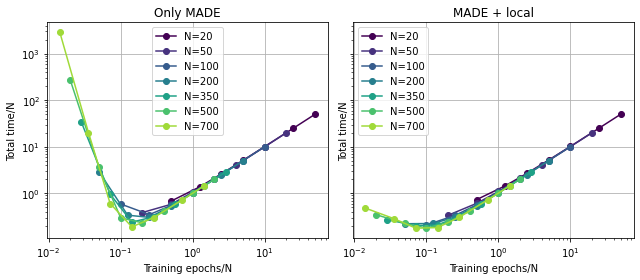

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey = True)

# Plot (d[:, 0] + d[:, 3]) on the first subplot
for i, d in enumerate(np.array(data)):
    axs[0].plot(d[1:, 0]/Ns[i], (d[1:, 0] + d[1:, 3])/Ns[i], marker="o", color=cmap(i / len(data)))
#axs[0].set_xlim(0, 200)
#axs[0].set_ylim(0, 500)
axs[0].set_ylabel(r'Total time/N')
axs[0].set_xlabel(r'Training epochs/N')
axs[0].grid(True)
axs[0].legend(labels=[f'N={N}' for N in Ns], loc='best')
axs[0].set_title(r'Only MADE')

# Plot (d[:, 0] + d[:, 4]) on the second subplot
for i, d in enumerate(np.array(data)):
    axs[1].plot(d[1:, 0]/Ns[i], (d[1:, 0] + d[1:, 4])/Ns[i], marker="o", color=cmap(i / len(data)))
    #axs[1].plot(data[i][:, 0], (data[i][:, 0] + data[i][:, 4]), marker="s", color=cmap(i / len(data)))

#axs[1].set_xlim(0, 200)
#axs[1].set_ylim(0, 500)
axs[1].set_ylabel(r'Total time/N')
axs[1].set_xlabel(r'Training epochs/N')
axs[1].grid(True)
axs[1].legend(labels=[f'N={N}' for N in Ns], loc='best')
axs[1].set_title(r'MADE + local')

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')



plt.tight_layout()

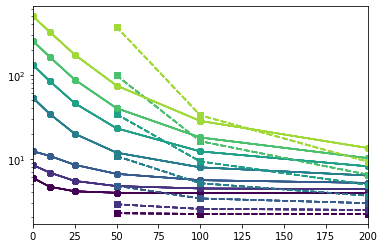

In [41]:
for d in data:
    cmap = plt.get_cmap('viridis')
    for i, d in enumerate(data):
        plt.plot(d[:, 0], d[:, 4], marker="o", color=cmap(i / len(data)))
        plt.plot(d[3:, 0], d[3:, 3], marker="s", ls = "--", color=cmap(i / len(data)))
#plt.xscale("log")
plt.xlim(0, 200)
plt.yscale("log")

In [15]:
all_results = []

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]
beta = 1

for i, N in enumerate(Ns):
    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    P = transition_matrix_local(N, beta_target)[:nmax, :nmax]
    P = torch.matrix_power(P, N)
    P = torch.eye(P.shape[0])-P
    P_inv = torch.linalg.inv(P)
    result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

    print(beta_target, mtarget, result[0].item() )
    all_results.append((beta_target, mtarget, result[0].item() ))
all_results_onlyMC = np.array(all_results)

1.1118033988749896 0.5267722209710917 2.119629383087158
1.0707106781186548 0.43321638618915215 2.965569019317627
1.05 0.37070573256992784 4.396831035614014
1.0353553390593273 0.3156711724359867 6.071971416473389
1.0267261241912424 0.27652547186691834 7.928994178771973
1.022360679774998 0.2539045057902792 9.309741973876953
1.0188982236504613 0.2341322682996002 10.746172904968262


In [20]:
all_results = []

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]
beta = 1

for i, N in enumerate(Ns):
    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    P = transition_matrix_local(N, beta_target)[:nmax, :nmax]
    P = torch.eye(P.shape[0])-P
    P_inv = torch.linalg.inv(P)
    result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

    print(beta_target, mtarget, result[0].item()/N )
    all_results.append((beta_target, mtarget, result[0].item()/N ))
all_results_onlyMC = np.array(all_results)

1.1118033988749896 0.5267722209710917 1.6504461288452148
1.0707106781186548 0.43321638618915215 2.4856942749023436
1.05 0.37070573256992784 3.9059381103515625
1.0353553390593273 0.3156711724359867 5.57490966796875
1.0267261241912424 0.27652547186691834 7.430069754464285
1.022360679774998 0.2539045057902792 8.810505859375
1.0188982236504613 0.2341322682996002 10.247283063616072


In [86]:
# Compute the eigenvalues of the matrix P
P = transition_matrix_local(N, beta_target)
eigenvalues = torch.linalg.eigvals(P)

# Get the second largest eigenvalue
sorted_eigenvalues = torch.sort(eigenvalues.real, descending=True).values
second_largest_eigenvalue = sorted_eigenvalues[1]

# Print the second largest eigenvalue
print("Second largest eigenvalue:", second_largest_eigenvalue.item())

Second largest eigenvalue: 0.9998191595077515


In [115]:
data[-3][:, 4]

array([131.7288438561163, 84.52006823008206, 45.989640541446704,
       23.078182429308644, 12.24681980808986, 8.13435890584363,
       6.390273513650873, 6.101389343069795], dtype=object)

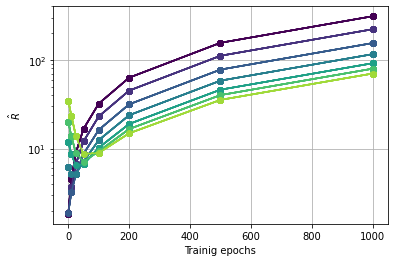

In [47]:
for d in data:
    cmap = plt.get_cmap('viridis')
    for i, d in enumerate(data):
        plt.plot(d[:, 0], (d[:, 0] + d[:, 4]) / all_results_onlyMC[i,2], marker="o", color=cmap(i / len(data)))
plt.yscale("log")
#plt.xlim(0, 200)
plt.ylabel(r'$\hat{R}$')
plt.xlabel(r'Trainig epochs')
plt.grid(True)

In [27]:
data[-1]

array([[0, 1.0188982236504613, 0.2341322682996002, 1015351854.1571069,
        498.42594130501766, 4.908898715891796e-07],
       [10, 1.0188982236504613, 0.2341322682996002, 2028042.1490072657,
        325.8375058442267, 0.00016066604237181432],
       [25, 1.0188982236504613, 0.2341322682996002, 14099.868463806215,
        173.88660320331252, 0.012332498253417918],
       [50, 1.0188982236504613, 0.2341322682996002, 372.2949623496356,
        74.46577248832807, 0.20001821141591108],
       [100, 1.0188982236504613, 0.2341322682996002, 32.95705666196262,
        28.25094355651617, 0.8572046905245028],
       [200, 1.0188982236504613, 0.2341322682996002, 9.252902610916506,
        13.455007504573741, 1.4541391031933724],
       [500, 1.0188982236504613, 0.2341322682996002, 4.448956988806097,
        7.896019455309737, 1.7748023806875863],
       [1000, 1.0188982236504613, 0.2341322682996002, 3.6326874840847396,
        6.706005986560035, 1.846017863066914]], dtype=object)

In [ ]:
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

In [56]:
def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = Tmade.dot(np.linalg.matrix_power(Tlocal, k*N))
    return T

In [32]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]
Ns = [700]

times = [0]

num_epochs = 1
for i, N in enumerate(Ns):
    results = []
    lr = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "random", pert_type="none", epochs = num_epochs, learning_rate=lr, patience=1000000, scheduler_time = 100000, batch_size=pop_size)
    #weights = [torch.zeros((N,N), device = "cuda")]
    for count, Wpert in enumerate(weights):

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0])-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

100%|██████████| 1/1 [00:00<00:00, 24.61it/s]

0 1.0188982236504613 0.2341322682996002 14.35543441772461 28.71086883544922 2.0


In [35]:
all_results = []

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]
beta = 1

for i, N in enumerate(Ns):
    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)

    P = transition_matrix_local(N, beta_target)
    P = torch.matrix_power(P, N)[:nmax, :nmax]
    P = torch.eye(P.shape[0])-P
    P_inv = torch.linalg.inv(P)
    result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

    print(beta_target, mtarget, result[0].item() )
    all_results.append((beta_target, mtarget, result[0].item() ))
all_results_onlyMC = np.array(all_results)

1.1118033988749896 0.5267722209710917 3.2358052730560303
1.0707106781186548 0.43321638618915215 4.53523063659668
1.05 0.37070573256992784 6.501209259033203
1.0353553390593273 0.3156711724359867 8.674814224243164
1.0267261241912424 0.27652547186691834 10.98210620880127
1.022360679774998 0.2539045057902792 12.65073013305664
1.0188982236504613 0.2341322682996002 14.355240821838379


In [50]:
data[-1]

array([[0, 1.0188982236504613, 0.2341322682996002, 1015351854.1571069,
        498.42594130501766, 4.908898715891796e-07],
       [10, 1.0188982236504613, 0.2341322682996002, 2028042.1490072657,
        325.8375058442267, 0.00016066604237181432],
       [25, 1.0188982236504613, 0.2341322682996002, 14099.868463806215,
        173.88660320331252, 0.012332498253417918],
       [50, 1.0188982236504613, 0.2341322682996002, 372.2949623496356,
        74.46577248832807, 0.20001821141591108],
       [100, 1.0188982236504613, 0.2341322682996002, 32.95705666196262,
        28.25094355651617, 0.8572046905245028],
       [200, 1.0188982236504613, 0.2341322682996002, 9.252902610916506,
        13.455007504573741, 1.4541391031933724],
       [500, 1.0188982236504613, 0.2341322682996002, 4.448956988806097,
        7.896019455309737, 1.7748023806875863],
       [1000, 1.0188982236504613, 0.2341322682996002, 3.6326874840847396,
        6.706005986560035, 1.846017863066914]], dtype=object)

In [91]:
def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

def montecarlo_alternated_abs(N, beta, target_M, model, pop_size = 10000, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N//2)), -torch.ones((pop_size, N//2))], dim=1).cuda()
    # Apply random permutation to each row
    pop = torch.stack([row[torch.randperm(row.size(0))] for row in pop])
    over = False

    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    # Loop to update the population using the Monte Carlo method
    for global_step in range(1, 1000):  # Maximum number of iterations
        pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        #magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        #newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        #time_to_target[newly_reached] = N+N+global_step*(N+N*k)
        
        # Mark members as having reached the target
        #reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    over = True
        #    break
        #
        # Perform a Monte Carlo update for the entire population
        for i in range(k):
            pop = monte_carlo_update_CW(pop, N, beta)  
        #pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = global_step
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        if reached_target.all():
            print("All population members have reached the target magnetization.")
            over = True
            break
        if over:
            break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target

In [54]:
beta = 1
N = 700
num_sweeps = 30

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model_exact = setup_model(W, N=N)
pop_size = 50000
pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

times = [0,10,25, 50, 100, 200, 500, 1000]
num_epochs = 1001
model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=1, patience=1000000, scheduler_time = 100000, batch_size=pop_size)

100%|██████████| 1001/1001 [00:38<00:00, 26.04it/s]


In [71]:
times = []

Ls = [0,5,10,15,20,50,100,200,500]
for L in Ls:
    nmax = int((mtarget)*N/2)
    Wchaged = weights[-1].copy()
    Wchaged[:L] = 0
    P = get_matrix_mixed(N, beta_target, Wchaged, k=1)[:nmax, :nmax]
    P = torch.eye(P.shape[0])-P
    P_inv = torch.linalg.inv(P)
    fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]
    print(2*fpt_made)
    times.append(2*fpt_made)

tensor(6.7034, dtype=torch.float64)
tensor(6.8001, dtype=torch.float64)
tensor(7.0433, dtype=torch.float64)
tensor(7.3951, dtype=torch.float64)
tensor(7.8032, dtype=torch.float64)
tensor(11.1847, dtype=torch.float64)
tensor(19.5422, dtype=torch.float64)
tensor(48.2561, dtype=torch.float64)
tensor(257.8787, dtype=torch.float64)


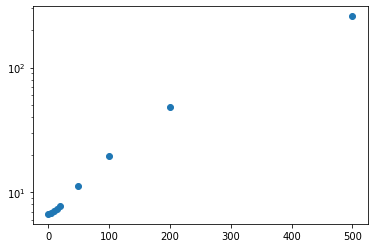

In [76]:
plt.scatter(Ls, times)
plt.yscale("log")

In [64]:
data[-1]

array([[0, 1.0188982236504613, 0.2341322682996002, 1015351854.1571069,
        498.42594130501766, 4.908898715891796e-07],
       [10, 1.0188982236504613, 0.2341322682996002, 2028042.1490072657,
        325.8375058442267, 0.00016066604237181432],
       [25, 1.0188982236504613, 0.2341322682996002, 14099.868463806215,
        173.88660320331252, 0.012332498253417918],
       [50, 1.0188982236504613, 0.2341322682996002, 372.2949623496356,
        74.46577248832807, 0.20001821141591108],
       [100, 1.0188982236504613, 0.2341322682996002, 32.95705666196262,
        28.25094355651617, 0.8572046905245028],
       [200, 1.0188982236504613, 0.2341322682996002, 9.252902610916506,
        13.455007504573741, 1.4541391031933724],
       [500, 1.0188982236504613, 0.2341322682996002, 4.448956988806097,
        7.896019455309737, 1.7748023806875863],
       [1000, 1.0188982236504613, 0.2341322682996002, 3.6326874840847396,
        6.706005986560035, 1.846017863066914]], dtype=object)

In [176]:
def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = Tmade.dot(np.linalg.matrix_power(Tlocal, k*N))
    #T = np.einsum("ij,jk->ik",Tmade, np.linalg.matrix_power(Tlocal, k*N))
    return T

In [179]:
mod = setup_model(torch.tensor(weights[-2]), N=N).cuda()

In [207]:
import numpy as np
from scipy.special import comb

def transition_matrix_global(probMADE, beta, N):
    probMADE = probMADE.cpu().numpy()
    M = len(probMADE)  # M should be N/2 + 1
    m_vals = np.arange(M) * (2.0 / N)  # m_i = 2*i/N, with m_max=1
    m2 = m_vals**2

    # Precompute the configuration counts (degeneracies)
    config = np.empty(M, dtype=float)
    config[0] = comb(N, N//2)
    for i in range(1, M):
        config[i] = 2 * comb(N, (N//2) + i)

    # Compute the exponent matrix: E[i,j] = 0.5 * beta * N * (m_vals[j]^2 - m_vals[i]^2)
    E = 0.5 * beta * N * (m2[None, :] - m2[:, None])
    
    # Compute the ratio for all i,j:
    # ratio[i,j] = exp(E[i,j]) * (probMADE[i] * config[j])/(probMADE[j] * config[i])
    ratio = np.exp(E) * (probMADE[:, None] * config[None, :]) / (probMADE[None, :] * config[:, None])
    
    # alpha[i,j] = min(1, ratio[i,j])
    alpha = np.minimum(1.0, ratio)
    
    # T[i,j] = probMADE[j] * alpha[i,j]  (for off-diagonals)
    T = probMADE[None, :] * alpha
    
    # Now set the diagonal entries T[i,i] = 1 - sum_{j ≠ i} T[i,j]
    off_diag_sum = T.sum(axis=1) - np.diag(T)
    np.fill_diagonal(T, 1.0 - off_diag_sum)
    return T


In [203]:
def transition_matrix_global(probMADE, beta, N):
    M = len(probMADE)  # M should be N/2 + 1
    T = np.zeros((M, M), dtype=float)
    m_vals = np.arange(M) * (2.0 / N)  # m_i = 2*i/N, with m_max=1
    
    # Precompute the configuration counts (degeneracies)
    config = np.zeros(M, dtype=float)
    config[0] = comb(N, N//2)
    for i in range(1, M):
        config[i] = 2 * comb(N, (N//2) + i)
    
    for i in range(M):
        m_i = m_vals[i]
        for j in range(M):
            if j != i:
                exponent = 0.5 * beta * N * (m_vals[j]**2 - m_i**2)
                ratio = np.exp(exponent) * (probMADE[i] * config[j]) / (probMADE[j] * config[i])
                alpha = min(1.0, ratio)
                T[i, j] = probMADE[j] * alpha
        T[i, i] = 1.0 - T[i, :].sum()
    return T

In [208]:
nmax = int((mtarget)*N/2)
P = get_matrix_mixed(N, beta_target, weights[2], k=1)[:nmax, :nmax]
P = torch.eye(P.shape[0])-P
P_inv = torch.linalg.inv(P)
fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]
print(fpt_made)

tensor(13.1976, dtype=torch.float64)


In [196]:
mod = setup_model(torch.tensor(weights[-1]), N=N).cuda()

In [198]:
mtarget = 0.2341322682996002
beta_target = 1.0188982236504613

result1 = 2*montecarlo_alternated_abs(N, beta_target, int(mtarget*N), mod, pop_size = 10000, k = N*1).mean()
print(result1)
result2 = montecarlo_alternated_abs(N, beta_target, int(mtarget*N), mod, pop_size = 10000, k = 0).mean()
print(result2)


All population members have reached the target magnetization.
tensor(6.5592, device='cuda:0')
All population members have reached the target magnetization.
tensor(3.7374, device='cuda:0')


In [149]:
data[-1]

array([[0, 1.0188982236504613, 0.2341322682996002, 1015351854.1571069,
        498.42594130501766, 4.908898715891796e-07],
       [10, 1.0188982236504613, 0.2341322682996002, 2028042.1490072657,
        325.8375058442267, 0.00016066604237181432],
       [25, 1.0188982236504613, 0.2341322682996002, 14099.868463806215,
        173.88660320331252, 0.012332498253417918],
       [50, 1.0188982236504613, 0.2341322682996002, 372.2949623496356,
        74.46577248832807, 0.20001821141591108],
       [100, 1.0188982236504613, 0.2341322682996002, 32.95705666196262,
        28.25094355651617, 0.8572046905245028],
       [200, 1.0188982236504613, 0.2341322682996002, 9.252902610916506,
        13.455007504573741, 1.4541391031933724],
       [500, 1.0188982236504613, 0.2341322682996002, 4.448956988806097,
        7.896019455309737, 1.7748023806875863],
       [1000, 1.0188982236504613, 0.2341322682996002, 3.6326874840847396,
        6.706005986560035, 1.846017863066914]], dtype=object)

In [38]:
N = 500
beta = 1

W = np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

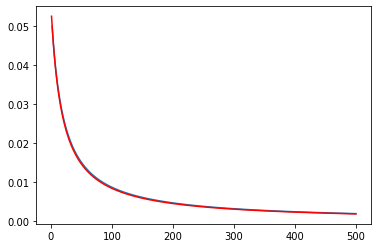

In [39]:
plt.plot(np.arange(2,N+1,1), W[1:], ls = "-")
c = 0.0499253
plt.plot(np.arange(1,N+1,1), c / (1 + (np.arange(1,N+1,1)-2)*c), color = "red")
#plt.yscale("log")
plt.show()

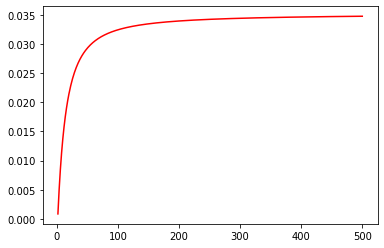

In [40]:
plt.plot(np.arange(2,N+1,1), (W[1:]-c / (1 + (np.arange(2,N+1,1)-2)*c))/W[1:], color = "red")
plt.show()